In [1]:
#default_exp verbatims/standard_themes_css/training

In [2]:
#all_slow

In [3]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Standard CSS Themes - Training

> This module contains all the bits required to train and evaluate CSS standard theme models

In [4]:
#export
import os, datetime, gc
import sklearn.metrics as skm

import optuna

from fastai.text.all import *
from transformers import *
from blurr.utils import *
from blurr.data.core import *
from blurr.modeling.core import *

from tritonlytics_ai.utils import *
from tritonlytics_ai.verbatims.core import *

from transformers import logging as hf_logging
hf_logging.set_verbosity_error()

In [5]:
#hide
import pdb

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

from nbdev.showdoc import *
from fastcore.test import *

In [6]:
#hide
from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.6.0
Using fastai 2.0.16
Using transformers 3.3.1


In [7]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}')

Using GPU #1


## Data

In [8]:
task = HF_TASKS_AUTO.SequenceClassification

pretrained_model_name = "facebook/bart-base" #"roberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = len(STANDARD_THEME_CSS_LABELS)

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)

In [9]:
df = get_css_standard_theme_train_data()
train_df, valid_df = df[df.is_valid == False], df[df.is_valid == True]

set_seed(TL_RAND_SEED)
dls = get_css_standard_theme_train_dls(df, hf_arch, hf_tokenizer)

In [10]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([8, 324]), torch.Size([8, 16]))

## Training

In [11]:
m_pre = f'exp_{m_pre_standard_themes_css}'
m_suf = m_suf_standard_themes_css
base_model_name = base_model_name_standard_themes_css

Configure our **metrics**

In [12]:
# define metrics
beta, start, end, average, sample_weight = .5, 0.08, 0.7, 'weighted', None

# custom
opt_th_metrics = OptimalMultiThresholdMetrics(beta=beta, start=start, end=end, 
                                              average=average, sample_weight=sample_weight)

opt_th_metric = opt_th_metrics.best_thresh()
opt_fscore_metric = opt_th_metrics.best_fscore()
opt_acc_metric = opt_th_metrics.best_faccuracy()

# standard
fbeta_metric = FBetaMulti(beta=beta, average=average, sample_weight=sample_weight)
prec_metric = PrecisionMulti(average=average, sample_weight=sample_weight)
recall_metric = RecallMulti(average=average, sample_weight=sample_weight)
roc_auc_metric = RocAucMulti(average=average, sample_weight=sample_weight)

In [8]:
#export
def get_metrics(train_config={}):
    config = {**css_standard_themes_train_config, **train_config}

    beta, average, sample_weight = config['opt_beta'], config['opt_beta_average'], config['opt_beta_sample_weight']
    start, end = config['opt_start'], config['opt_end']
    
    # fbeta and roc-auc metrics
    fbeta_metric = FBetaMulti(beta=beta, average=average, sample_weight=sample_weight)
    prec_metric = PrecisionMulti(average=average, sample_weight=sample_weight)
    recall_metric = RecallMulti(average=average, sample_weight=sample_weight)
    roc_auc_metric = RocAucMulti(average=average, sample_weight=sample_weight)
    
    return [ accuracy_multi, fbeta_metric, prec_metric, recall_metric, roc_auc_metric ]

Configure our **loss**

In [14]:
label_counts = { col: train_df[col].value_counts().to_dict() for col in dls.tfms[1].vocab }
most_common_label = max(label_counts.keys(), key=(lambda k: label_counts[k][1]))

for lbl in label_counts: label_counts[lbl]['weight'] = label_counts[most_common_label][1] / label_counts[lbl][1]
    
pos_weight_vec = [v['weight'] * 1. if v['weight'] != 1.0 else v['weight'] for k,v in label_counts.items()]
# pos_weight_vec

In [15]:
# loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=tensor(pos_weight_vec).to('cuda:1'))
# loss_func.thresh = 0.5
# loss_func = BCEWithLogitsLossFlat(pos_weight=tensor(pos_weight_vec*bsz, device=torch.cuda.current_device()))
loss_func = BCEWithLogitsLossFlat()

In [9]:
#export
def get_loss_func(dls, train_df=None, use_weighted=False):
    if (use_weighted and train_df is not None):
        label_counts = { col: train_df[col].value_counts().to_dict() for col in dls.tfms[1].vocab }
        most_common_label = max(label_counts.keys(), key=(lambda k: label_counts[k][1]))

        for lbl in label_counts: 
            label_counts[lbl]['weight'] = label_counts[most_common_label][1] / label_counts[lbl][1]

        pos_weight_vec = [v['weight'] * 1. if v['weight'] != 1.0 else v['weight'] for k,v in label_counts.items()]
        
        loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=tensor(pos_weight_vec).to(dls.device))
        loss_func.thresh = 0.5 # adding "thresh" since we want to optimize this for our target beta
    else:
        loss_func = BCEWithLogitsLossFlat()
        
    return loss_func

In [17]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=False)
test_is(type(tst_loss_func), BCEWithLogitsLossFlat)

In [18]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=True)
test_is(type(tst_loss_func), torch.nn.BCEWithLogitsLoss)
test_eq(len(tst_loss_func.pos_weight), dls.c)
test_eq(dls.device, tst_loss_func.pos_weight.device)

Configure our **callbacks**

In [19]:
best_model_cb = SaveModelCallback(monitor='precision_score', 
                                  comp=np.greater, 
                                  reset_on_fit=False,
                                  fname=f'{m_pre}{base_model_name}{m_suf}_bestmodel')

opt_thresh_cb = OptimizeFBetaThreshCallback(beta=beta, 
                                            average=average, 
                                            sample_weight=sample_weight,
                                            start=start, end=end)

In [10]:
#export
def get_cbs(train_config={}, add_save_model_cb=True):
    config = {**css_standard_themes_train_config, **train_config}
    
    fit_cbs = []
    
    best_model_cb = SaveModelCallback(monitor=config['save_model_monitor'], 
                                      comp=config['save_model_comp'], 
                                      fname=config['save_model_filename'],
                                      reset_on_fit=False)

    opt_thresh_cb = OptimizeFBetaThreshCallback(beta=config['opt_beta'], 
                                                average=config['opt_beta_average'], 
                                                sample_weight=config['opt_beta_sample_weight'],
                                                start=config['opt_start'], end=config['opt_end'])
    
    if (add_save_model_cb): fit_cbs.append(best_model_cb)
    fit_cbs.append(opt_thresh_cb)
    
    return [HF_BaseModelCallback], fit_cbs # (learn_cbs, fit_cbs)

Define our **Learner**

In [21]:
try: del learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [22]:
learn_metrics = [ accuracy_multi, fbeta_metric, prec_metric, recall_metric, roc_auc_metric ]

learn_cbs = [HF_BaseModelCallback]
fit_cbs = [best_model_cb, opt_thresh_cb]

# build learner
model = HF_BaseModelWrapper(hf_model)

set_seed(TL_RAND_SEED)
learn = Learner(dls, 
                model,
                opt_func=partial(Adam, mom=0.9, sqr_mom=0.98, eps=1e-6, weight_decay=0.1),
                loss_func=loss_func,
                metrics=learn_metrics,
                cbs=learn_cbs,
                splitter=hf_splitter,
                path=STANDARD_THEME_CSS_PATH)

learn.create_opt() # -> will create your layer groups based on your "splitter" function
learn.freeze()

In [23]:
# learn.blurr_summary()

In [24]:
# learn.show_training_loop()

In [25]:
# Note: Run this to test the model and comment out afterwards as it needlessly contributes to GPU RAM utilization :(
# preds = model(b[0]); preds[0].shape

In [11]:
#export
def get_learner(hf_model, dls, train_df=None, use_weighted_loss=False, use_fp16=True,
                opt_func=partial(Adam, mom=0.9, sqr_mom=0.98, eps=1e-6, weight_decay=0.1),
                add_save_model_cb=True, train_config={}):
    config = {**css_standard_themes_train_config, **train_config}
    
    # build learner
    model = HF_BaseModelWrapper(hf_model)
    loss_func = get_loss_func(dls, train_df, use_weighted_loss)
    learn_cbs, fit_cbs = get_cbs(config, add_save_model_cb=add_save_model_cb)
    learn_metrics = get_metrics(config)

    set_seed(TL_RAND_SEED)
    learn = Learner(dls, model, loss_func=loss_func, opt_func=opt_func, 
                    metrics=learn_metrics, cbs=learn_cbs, splitter=hf_splitter, path=config['learner_path'])
    
    if (use_fp16): learn = learn.to_fp16()
    learn.create_opt() # -> will create your layer groups based on your "splitter" function
    learn.freeze()
    
    return learn, fit_cbs

(0.002754228748381138, 0.0002290867705596611)

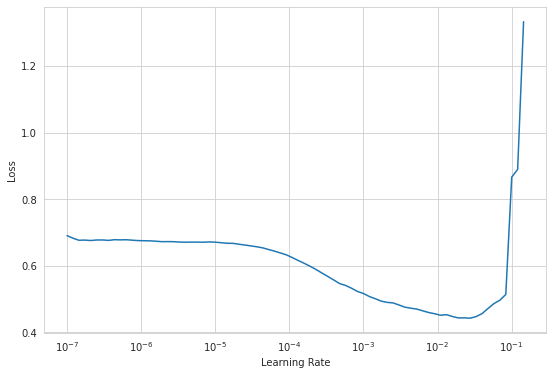

In [27]:
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [28]:
set_seed(TL_RAND_SEED)
learn.fit_one_cycle(3, lr_max=lr_min, cbs=fit_cbs)
# learn.fit_flat_cos(10, lr_max=lr_min, cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.209616,0.180761,0.934315,0.561130,0.616212,0.563636,0.761717,0.300000,00:25
1,0.167806,0.155399,0.945462,0.633268,0.734432,0.519481,0.747958,0.470000,00:25
2,0.117148,0.133298,0.953623,0.683633,0.794989,0.498701,0.743341,0.630000,00:25


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.6162118428555228.
Better model found at epoch 1 with precision_score value: 0.734432243432039.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 2 with precision_score value: 0.7949894152083011.


(1.0964781722577755e-07, 5.754399353463668e-06)

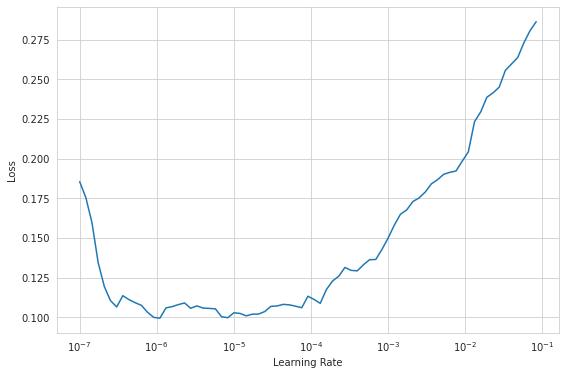

In [29]:
learn.unfreeze()
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [30]:
set_seed(TL_RAND_SEED)
learn.fit_one_cycle(5, lr_max=slice(lr_min/10, lr_min), cbs=fit_cbs)
# learn.fit_flat_cos(5, lr_max=slice(lr_min/10, lr_min), cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.092488,0.133298,0.953822,0.682259,0.798885,0.496104,0.742258,0.640000,00:48
1,0.084585,0.133268,0.953822,0.683703,0.802026,0.493506,0.741128,0.650000,00:48
2,0.112068,0.133269,0.953623,0.681734,0.792528,0.501299,0.744321,0.640000,00:48
3,0.094914,0.133268,0.953623,0.681734,0.792528,0.501299,0.744321,0.640000,00:48
4,0.096413,0.133265,0.953623,0.681734,0.792528,0.501299,0.744321,0.640000,00:48


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.7988849136492542.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.8020257028431208.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
learn.loss_func.thresh # => not part of pytorch BCE loss function (so added above as needed)

0.6399999999999997

In [32]:
learn.save(f'{m_pre}{base_model_name}{m_suf}')

Path('data/classification/standard_themes/css/models/exp_verbatim_standard_theme_css_multilabel_hf.pth')

Export model for inference

In [33]:
learn.export(fname=f'{m_pre}{base_model_name}{m_suf}_export.pkl')

Look at results

In [34]:
# have to add in the opthmize threshold cb since its used as *not* associated to the learner
scores = dict(zip(learn.recorder.metric_names[2:], learn.validate(cbs=[fit_cbs[-1]]))); scores

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'valid_loss': 0.13326804339885712,
 'accuracy_multi': 0.9538216590881348,
 'fbeta_score': 0.6837028838906533,
 'precision_score': 0.8020257028431208,
 'recall_score': 0.4935064935064935,
 'roc_auc_score': 0.7411276914116458,
 'opt_th': 0.6499999999999997}

In [35]:
# learn.show_results(learner=learn, max_n=2) 
# => ERROR:Only one class present in y_true. ROC AUC score is not defined in that case.

Use it for inference

In [36]:
inf_learn = load_learner(STANDARD_THEME_CSS_PATH/f'{m_pre}{base_model_name}{m_suf}_export.pkl')

In [37]:
inf_learn.loss_func.thresh = scores['opt_th']
inf_learn.loss_func.thresh

0.6499999999999997

In [38]:
inf_learn.blurr_predict('We are not paid enough and the benefits are horrible')

((#1) ['cost_fees'],
 tensor([False, False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False]),
 tensor([5.3415e-03, 6.7823e-04, 7.2946e-01, 4.5085e-03, 1.7117e-03, 5.7618e-04,
         1.4668e-02, 2.6482e-03, 2.1418e-03, 7.3216e-02, 3.5675e-03, 1.0945e-03,
         1.0137e-03, 5.1155e-03, 2.2830e-03, 8.9258e-03]))

Review final validation loss for best model

In [39]:
print(STANDARD_THEME_CSS_LABELS)

['accessible_to_customers', 'consistency_in_policies_information', 'cost_fees', 'courteous_professional_staff', 'effective_communications', 'effectively_uses_websites_online_documentation', 'helpful_staff', 'knowledgeable_staff', 'moving_in_a_positive_direction', 'overall_satisfaction', 'process_improvement', 'provides_effective_advice_guidance', 'provides_training_on_processes_applications', 'resolves_problems_effectively', 'responds_to_requests_within_an_acceptable_time', 'understands_my_needs_and_requirements']


In [40]:
learn = learn.load(f'{m_pre}{base_model_name}{m_suf}_bestmodel')
learn.loss_func.thresh = scores['opt_th']
probs, targs, loss = learn.get_preds(dl=dls.valid, with_loss=True)

print(f'Validation Loss: {loss.mean()}')
# print(f'Validation Loss (per label): {loss.mean(dim=0)}') # ... no longer works (see forum comment from sylvain)

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 0.1332680583000183


In [41]:
learn.blurr_predict("The faculty really support us well!!!  It's great working and I feel valued")

((#0) [],
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False]),
 tensor([0.0015, 0.0012, 0.0030, 0.0203, 0.0016, 0.0012, 0.3695, 0.0363, 0.0026,
         0.2334, 0.0024, 0.0052, 0.0039, 0.0039, 0.0007, 0.0533]))

## Review

In [42]:
try: del learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [43]:
# predictions for a single model using the learner's model and data loaders
set_seed(TL_RAND_SEED)
learn, fit_cbs = get_learner(hf_model, 
                             dls, 
                             train_df=train_df, 
                             use_weighted_loss=False, 
                             use_fp16=True,
                             train_config={})

learn = learn.load(f'{m_pre}{base_model_name}{m_suf}_bestmodel')
learn.loss_func.thresh = scores['opt_th']
learn.model.cuda(1)
probs, targs  = learn.get_preds()

probs.shape, targs.shape, len(dls.valid_ds), dls.c, learn.loss_func.thresh

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(torch.Size([314, 16]), torch.Size([314, 16]), 314, 16, 0.6499999999999997)

### Lets look at validation metrics

In [44]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [45]:
threshold_f05 = f05.opt_th(probs, targs)
threshold_f1 = f1.opt_th(probs, targs)
threshold_f2 = f2.opt_th(probs, targs)

threshold_f05, threshold_f1, threshold_f2

(0.4800000000000001, 0.31000000000000005, 0.11000000000000001)

In [46]:
f05_score = f05.opt_fscore(probs, targs)
f1_score = f1.opt_fscore(probs, targs)
f2_score = f2.opt_fscore(probs, targs)

f05_score, f1_score, f2_score

(0.6754797370795996, 0.6552240106104489, 0.711913074994563)

In [47]:
# make sure we are getting the same f1 score as sklearn
res = skm.fbeta_score(targs, (probs > threshold_f05), beta=.5, 
                      average=average, sample_weight=sample_weight, zero_division=False)
res

0.6754797370795996

In [48]:
# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs, targs, threshold_f2, sigmoid=False).item()

val_acc_f05, val_acc_f1, val_acc_f2

(0.9518312215805054, 0.9476512670516968, 0.9118232727050781)

In [49]:
# make sure we are getting the same f1 accuracy
preds = ((probs > threshold_f05).byte() == targs.byte()).float().mean()
preds.item()

0.9518312215805054

### Overall metrics

In [50]:
eval_targs = targs.flatten()
eval_probs = probs.flatten()

#### Classification Accuracy

The percentage of correct predictions.  Answers the question, *"Overall, how often is the classifier correct?"*

In [51]:
# In multilabel classification, this function computes subset accuracy: 
# the set of labels predicted for a sample must exactly match ALL the corresponding set of labels in y_true.
print(skm.accuracy_score(targs, (probs > threshold_f05), sample_weight=sample_weight))

0.5191082802547771


In [52]:
print(skm.accuracy_score(eval_targs, (eval_probs > threshold_f05).float(), sample_weight=sample_weight))

0.9518312101910829


#### Null Accuracy
 
The accuracy achieved by always predicting the most frequent class.  Answers the question, *"What would the accuracy be by always predicting the most frequent case?"*

In [53]:
u_classes, u_counts = np.unique(eval_targs, return_counts=True)
most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
print(most_freq_class, most_freq_class_count)

0.0 4639


In [54]:
most_freq_class_count / len(eval_targs)

0.9233678343949044

#### Cohen's kappa

This measure is intended to compare labelings by different human annotators (not a classifier vs. ground truth)

Kappa socres are between -1 and 1 ( >= .8 is generally considered good agreement; <= 0 means no agreement ... e.g., practically random labels)

In [55]:
print(skm.cohen_kappa_score(eval_targs, (eval_probs > threshold_f05).float(), 
                            weights=None, sample_weight=sample_weight))

0.617750015562798


#### Confusion Matrix

Describes the performance of a classification model

In [56]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues, print_info=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_info): print("Normalized confusion matrix")
    else:
        if (print_info): print('Confusion matrix, without normalization')

    if (print_info): print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)

In [57]:
cm = skm.confusion_matrix(eval_targs, (eval_probs > threshold_f05).float(), sample_weight=sample_weight)

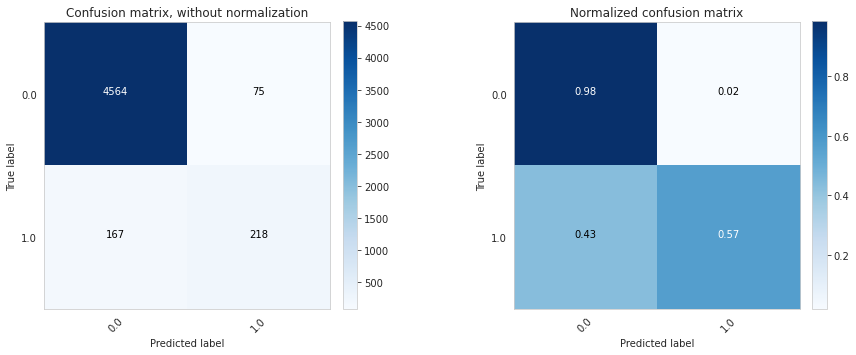

In [58]:
# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, classes=u_classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, classes=u_classes, normalize=True,
                      title='Normalized confusion matrix')

fig.subplots_adjust(wspace=0.5)
plt.show()

In [59]:
cm = skm.multilabel_confusion_matrix(targs, (probs > threshold_f05).float(), sample_weight=sample_weight)

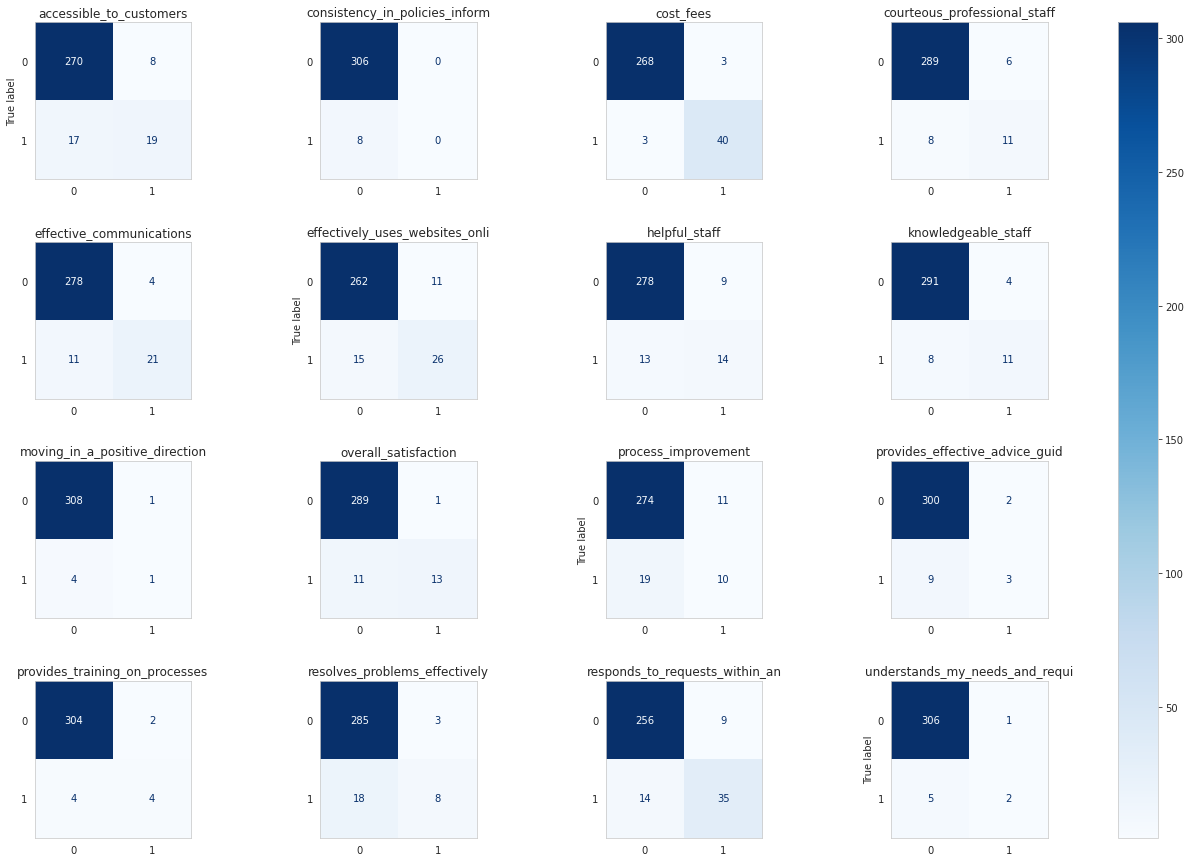

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay

f, axes = plt.subplots(4, 4, figsize=(25, 15))
axes = axes.ravel()
for i in range(16):
    disp = ConfusionMatrixDisplay(cm[i], display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='.4g', cmap=plt.cm.Blues)
    disp.ax_.set_title(STANDARD_THEME_CSS_LABELS[i][:30])
    disp.ax_.grid(False)
    if i<20:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.4)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [61]:
print(skm.classification_report(eval_targs, (eval_probs > threshold_f05).float(), 
                                labels=[0,1], 
                                sample_weight=sample_weight, 
                                zero_division=1))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4639
           1       0.74      0.57      0.64       385

    accuracy                           0.95      5024
   macro avg       0.85      0.78      0.81      5024
weighted avg       0.95      0.95      0.95      5024



In [62]:
classification_report = skm.classification_report(targs, (probs > threshold_f05).float(), 
                                target_names=STANDARD_THEME_CSS_LABELS,
                                sample_weight=sample_weight,
                                zero_division=1,
                                output_dict=True)

pd.DataFrame(classification_report).transpose()

,precision,recall,f1-score,support
accessible_to_customers,0.703704,0.527778,0.603175,36.0
consistency_in_policies_information,1.000000,0.000000,0.000000,8.0
cost_fees,0.930233,0.930233,0.930233,43.0
courteous_professional_staff,0.647059,0.578947,0.611111,19.0
effective_communications,0.840000,0.656250,0.736842,32.0
effectively_uses_websites_online_documentation,0.702703,0.634146,0.666667,41.0
helpful_staff,0.608696,0.518519,0.560000,27.0
knowledgeable_staff,0.733333,0.578947,0.647059,19.0
moving_in_a_positive_direction,0.500000,0.200000,0.285714,5.0
overall_satisfaction,0.928571,0.541667,0.684211,24.0


#### Raw probability distribution

Useful to see how the threshold can be adjusted to increase sensitivity or specificity

Text(0, 0.5, 'Frequency')

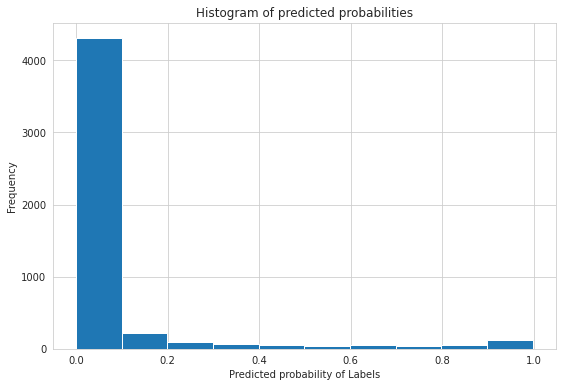

In [63]:
plt.hist(eval_probs, bins=10)
# plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of Labels')
plt.ylabel('Frequency')

#### ROC curves and Area Under the Curve (AUC)

***ROC Curve*** answers the question, *"How would sensitivity and specificity be affected by various thresholds without changing the threshold?"*  It is a way **to visualize the performance of a binary classifier.**

The ROC curve can help you **choose a threshold** that balances sensitivity and specificity based on your particular business case.

ROC curves visualize all possible classification thresholds whereas misclassification rate only represents your error rate for a single threshold.

A classifier that does a good job at separating the classes will have a ROC curve that hugs the upper left corner of the plot.  Converseley, a classifier the does a poor job separating the classes will have a ROC curve that is close to the diagonal line (0,0 -> 1,1).  That diagonal line represents a classifier that does no better than random guessing.

In [64]:
fpr, tpr, thresholds = skm.roc_curve(eval_targs, eval_probs, sample_weight=sample_weight)

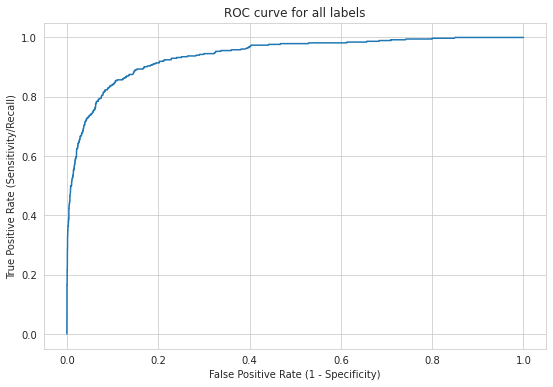

In [65]:
plt.plot(fpr, tpr)
plt.xlim = ([0.0, 1.0])
plt.ylim = ([0.0, 1.0])
plt.title('ROC curve for all labels')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.grid(True)

***AUC*** = the percentage of the ROC plot that is underneath the curve.  

AUC summarizes the performance of a classifier in a **single number**.  It says, *"If you randomly chose one positive and one negative observation, what is the likelihood that your classifier will assign a higher predicted probability to the positive observation."*

**An AUC of ~ 0.8 is very good while an AUC of ~ 0.5 represents a poor classifier.**

The ROC curve and AUC are insensitive to whether your predicted probabilities are properly calibrated to actually represent probabilities of class membership (e.g., it works if predicted probs range from 0.9 to 1 instead of 0 to 1).  All the AUC metric cares about is how well your classifier separated the two classes

Notes:
1.  AUC is useful even when there is **high class imbalance** (unlike classification accuracy)
2.  AUC is useful even when predicted probabilities are not properly calibrated (e.g., not between 0 and 1)

In [66]:
print(skm.roc_auc_score(eval_targs, eval_probs, average=average, sample_weight=sample_weight))

0.9403440060693778


### Let's look at things by label by label

In [67]:
label_metrics = {
    'thresholds': { 'f-beta05': threshold_f05, 'f-beta1': threshold_f1, 'f-beta2': threshold_f2 }
}

for idx, lbl in enumerate(STANDARD_THEME_CSS_LABELS):
    lbl_name, lbl_idx, lbl_targs, lbl_probs = lbl, idx, targs[:,idx], probs[:, idx]
    
    label_metrics[lbl_name] = {}
    label_metrics[lbl_name]['accuracies'] = {}
    label_metrics[lbl_name]['cohen_kappas'] = {}
    label_metrics[lbl_name]['confusion_matrices'] = {}
    label_metrics[lbl_name]['roc'] = {}
    label_metrics[lbl_name]['report'] = {}
    
    # get null accuracy (accuracy we'd get if we simply predicted the most common class)
    u_classes, u_counts = np.unique(lbl_targs, return_counts=True)
    most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
    label_metrics[lbl_name]['null_accuracy'] = most_freq_class_count / len(lbl_targs)
    
    # get raw probability distribution
    label_metrics[lbl_name]['probability_distribution'] = np.histogram(lbl_probs)
    
    # roc/auc curve metrics
    label_metrics[lbl_name]['roc_auc'] = skm.roc_auc_score(lbl_targs, lbl_probs, 
                                                           average=average, sample_weight=sample_weight)
    
    fpr, tpr, thresholds = skm.roc_curve(lbl_targs, lbl_probs, sample_weight=sample_weight)
    label_metrics[lbl_name]['roc']['fpr'] = fpr
    label_metrics[lbl_name]['roc']['tpr'] = tpr
    label_metrics[lbl_name]['roc']['thresholds'] = thresholds
    
    for k,v in label_metrics['thresholds'].items():
        label_metrics[lbl_name]['accuracies'][k] = skm.accuracy_score(lbl_targs, (lbl_probs > v), 
                                                                      sample_weight=sample_weight)
        
        label_metrics[lbl_name]['cohen_kappas'][k] = skm.cohen_kappa_score(lbl_targs, (lbl_probs > v), 
                                                                           sample_weight=sample_weight)
        
        label_metrics[lbl_name]['confusion_matrices'][k] = skm.confusion_matrix(lbl_targs, (lbl_probs > v), 
                                                                                sample_weight=sample_weight)
        
        precision, recall, fbeta_score, support = skm.precision_recall_fscore_support(lbl_targs, 
                                                                                      (lbl_probs > v), 
                                                                                      average=None, 
                                                                                      sample_weight=sample_weight)
        label_metrics[lbl_name]['report'][k] = {}
        label_metrics[lbl_name]['report'][k]['precision'] = precision
        label_metrics[lbl_name]['report'][k]['recall'] = recall
        label_metrics[lbl_name]['report'][k]['fbeta_score'] = fbeta_score
        label_metrics[lbl_name]['report'][k]['support'] = support
          
          

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
# label_metrics

ACCESSIBLE_TO_CUSTOMERS

Null Accuracy:	0.8853503184713376
AUC Score:	0.9224620303756994

		f-beta05(0.48)		f-beta1(0.31)		f-beta2(0.11)
Accuracy:	0.9203821656050956	0.9235668789808917	0.8471337579617835	
Cohen's Kappa:	0.5599282430765782	0.6141716158099529	0.47535505430242275	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9408              0.9712              0.9558              278                 
1                   0.7037              0.5278              0.6032              36                  
avg/total           0.8222              0.7495              0.7795              314                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9536              0.9604              0.957               278                 
1                   0.6765              0.6389              0.6571      

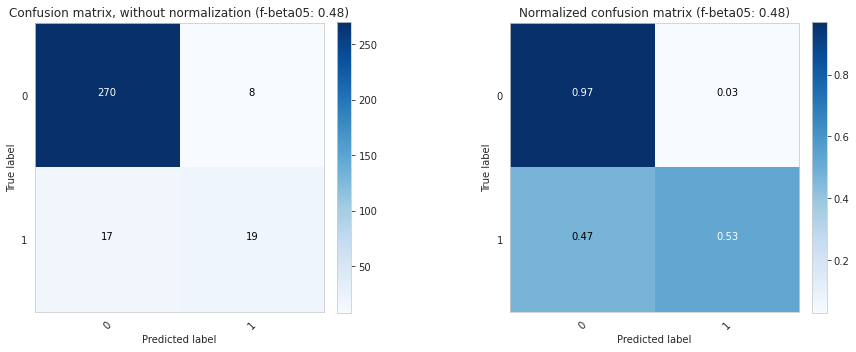

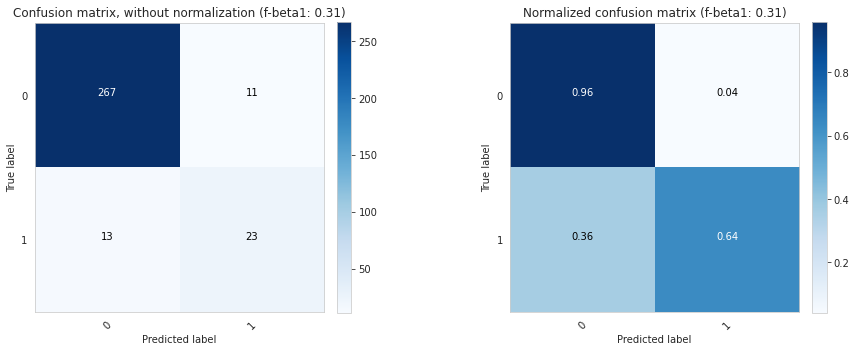

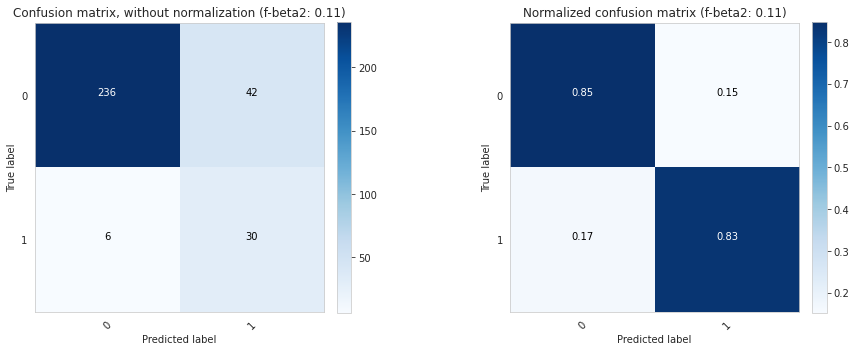



ROC Curve:


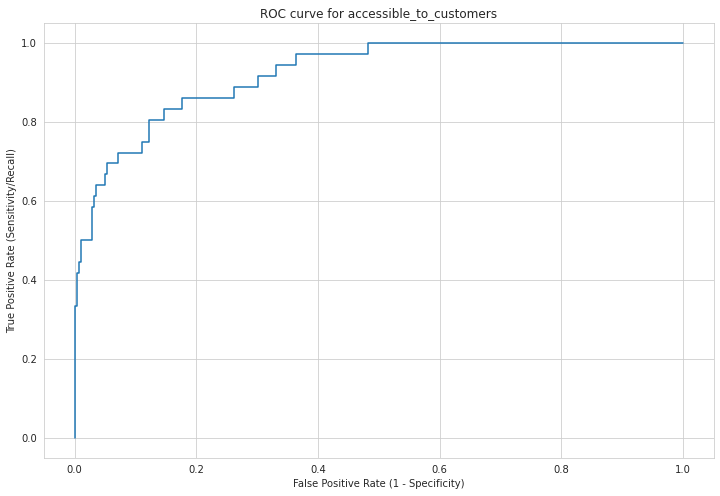

Predicted Probability Distribution:


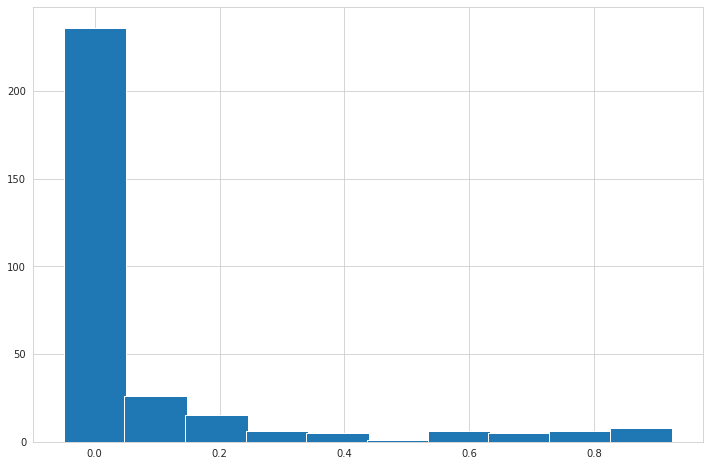



----------------------------------------------------------------------------------------------------


CONSISTENCY_IN_POLICIES_INFORMATION

Null Accuracy:	0.9745222929936306
AUC Score:	0.8937908496732025

		f-beta05(0.48)		f-beta1(0.31)		f-beta2(0.11)
Accuracy:	0.9745222929936306	0.9681528662420382	0.9363057324840764	
Cohen's Kappa:	0.0	-0.01029601029601035	0.13736263736263732	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9745              1.0                 0.9871              306                 
1                   0.0                 0.0                 0.0                 8                   
avg/total           0.4873              0.5                 0.4935              314                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9744              0.9935              0.9838   

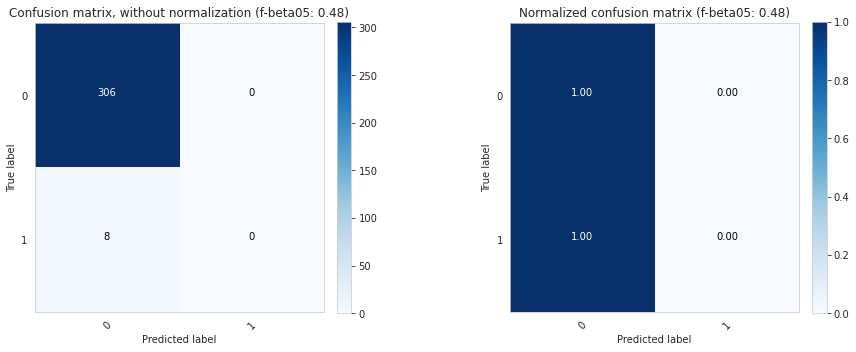

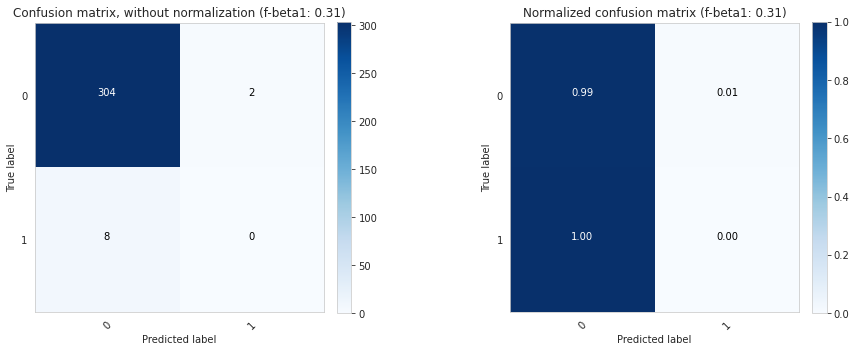

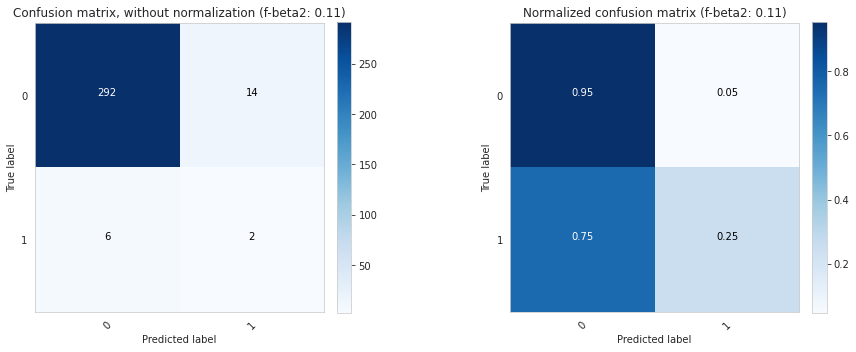



ROC Curve:


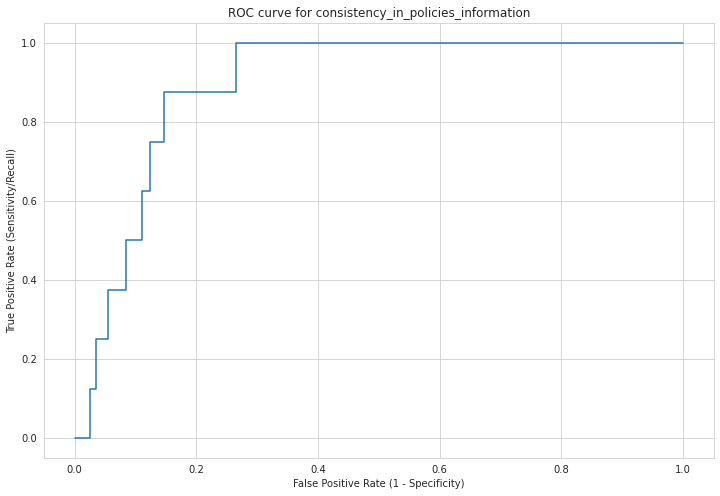

Predicted Probability Distribution:


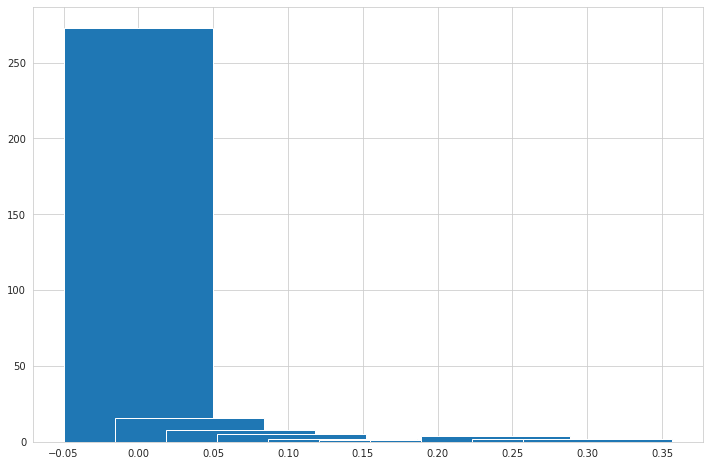



----------------------------------------------------------------------------------------------------


COST_FEES

Null Accuracy:	0.8630573248407644
AUC Score:	0.992791555822535

		f-beta05(0.48)		f-beta1(0.31)		f-beta2(0.11)
Accuracy:	0.9808917197452229	0.9713375796178344	0.9617834394904459	
Cohen's Kappa:	0.9191624474384279	0.8843982655649186	0.8527319627921519	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9889              0.9889              0.9889              271                 
1                   0.9302              0.9302              0.9302              43                  
avg/total           0.9596              0.9596              0.9596              314                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9925              0.9742              0.9832              271 

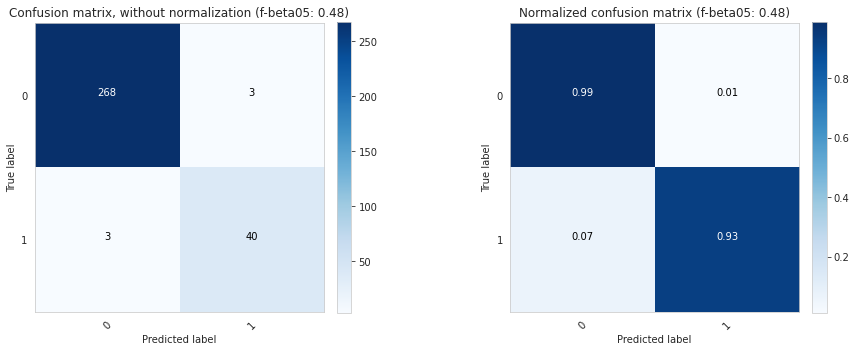

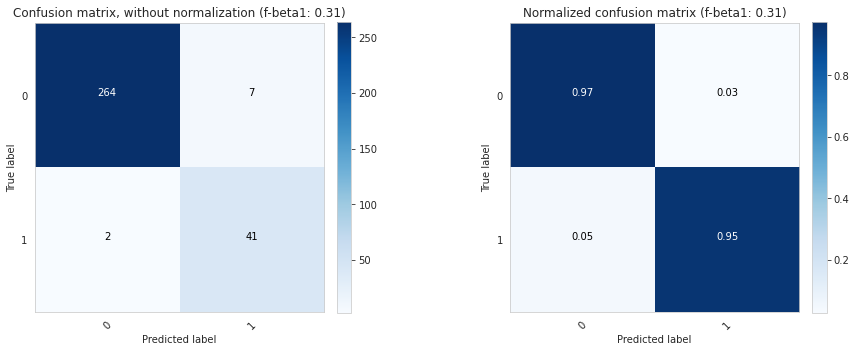

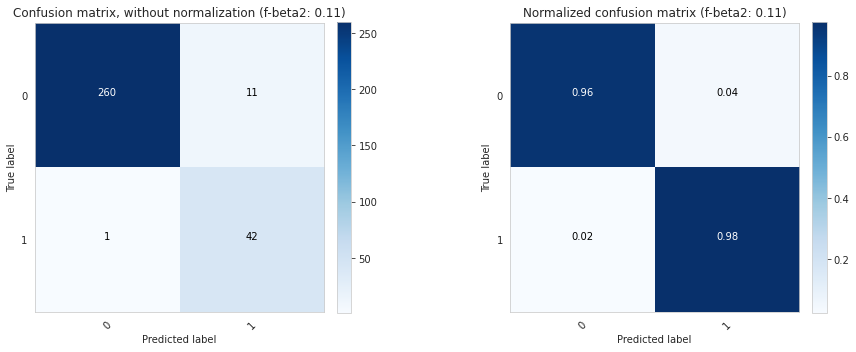



ROC Curve:


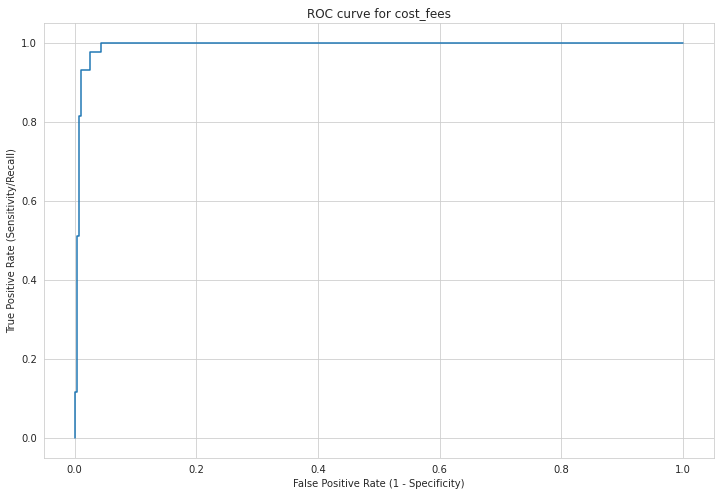

Predicted Probability Distribution:


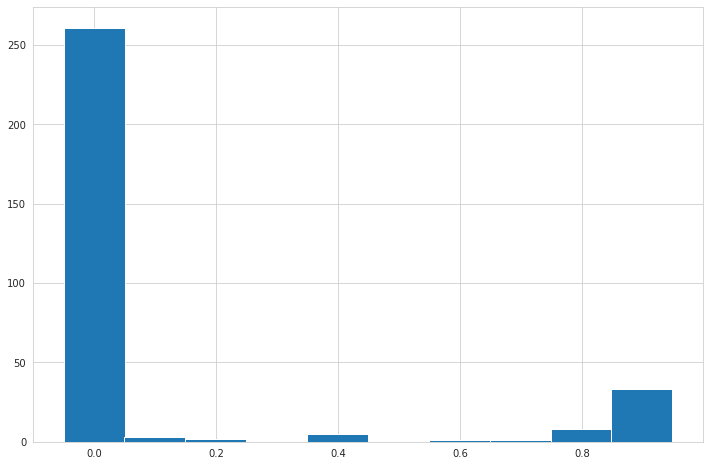



----------------------------------------------------------------------------------------------------


COURTEOUS_PROFESSIONAL_STAFF

Null Accuracy:	0.9394904458598726
AUC Score:	0.9463871543264941

		f-beta05(0.48)		f-beta1(0.31)		f-beta2(0.11)
Accuracy:	0.9554140127388535	0.9490445859872612	0.9203821656050956	
Cohen's Kappa:	0.5875398761493713	0.551828724353256	0.5063514023393283	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9731              0.9797              0.9764              295                 
1                   0.6471              0.5789              0.6111              19                  
avg/total           0.8101              0.7793              0.7937              314                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9729              0.9729              0.972

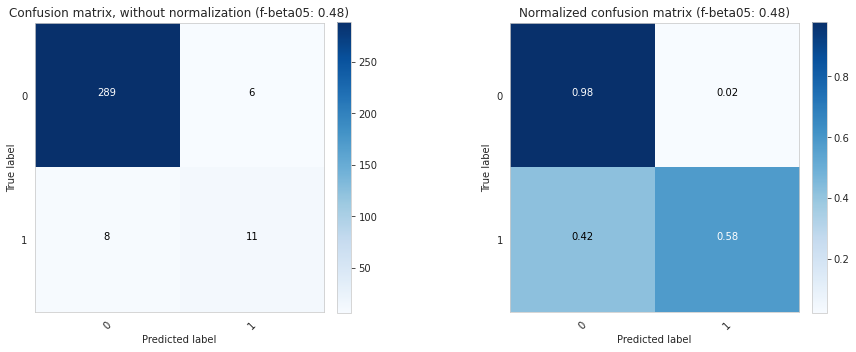

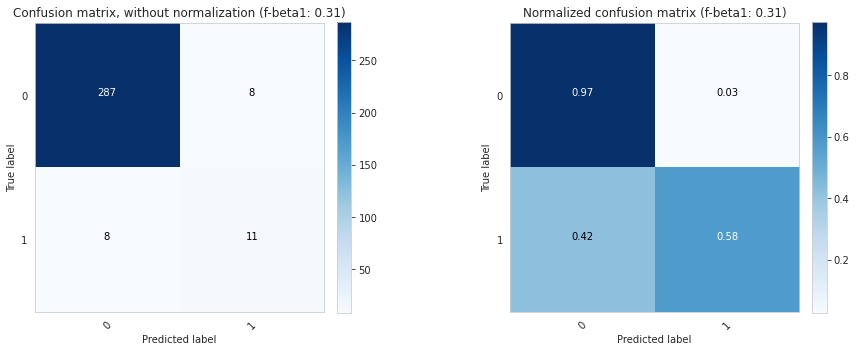

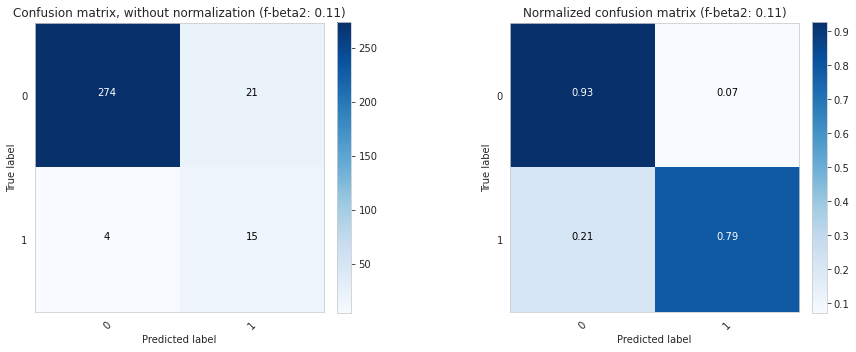



ROC Curve:


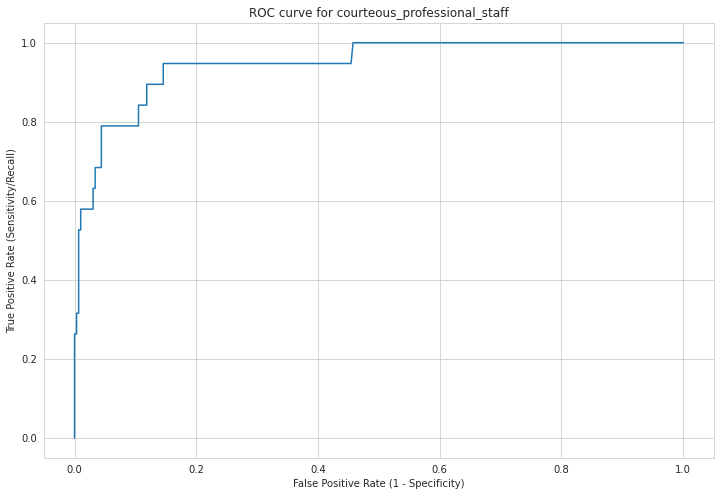

Predicted Probability Distribution:


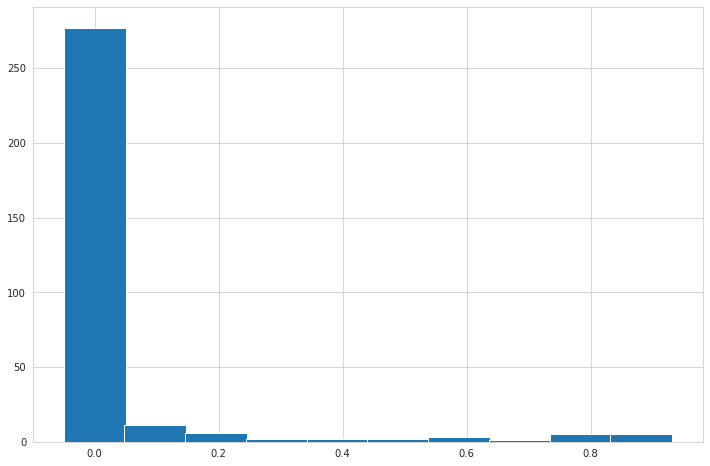



----------------------------------------------------------------------------------------------------


EFFECTIVE_COMMUNICATIONS

Null Accuracy:	0.8980891719745223
AUC Score:	0.9611591312056738

		f-beta05(0.48)		f-beta1(0.31)		f-beta2(0.11)
Accuracy:	0.9522292993630573	0.9522292993630573	0.9299363057324841	
Cohen's Kappa:	0.7110074855810529	0.7353635239914598	0.6717977955150133	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9619              0.9858              0.9737              282                 
1                   0.84                0.6562              0.7368              32                  
avg/total           0.901               0.821               0.8553              314                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9717              0.9752              0.9735  

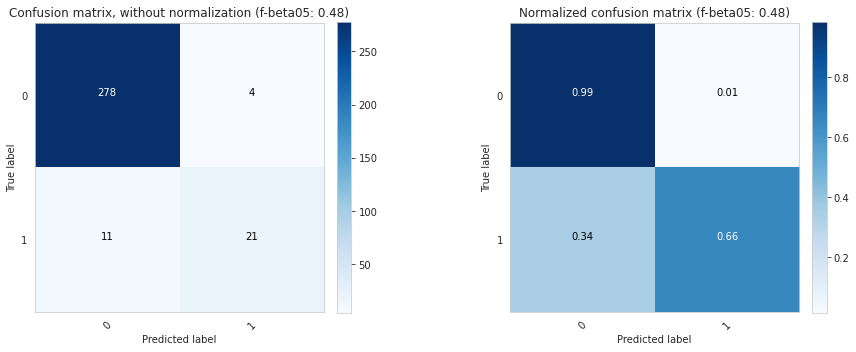

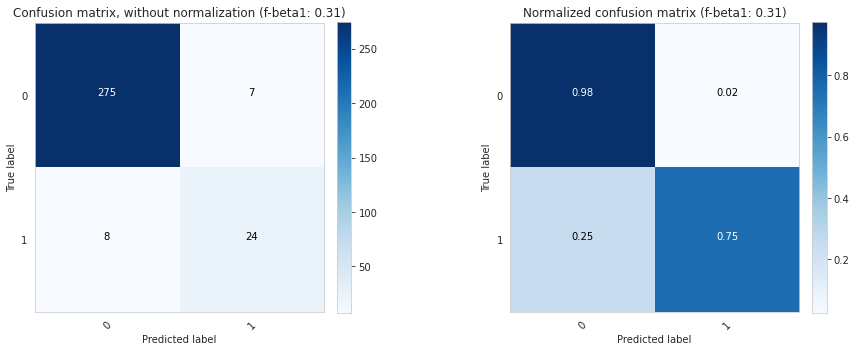

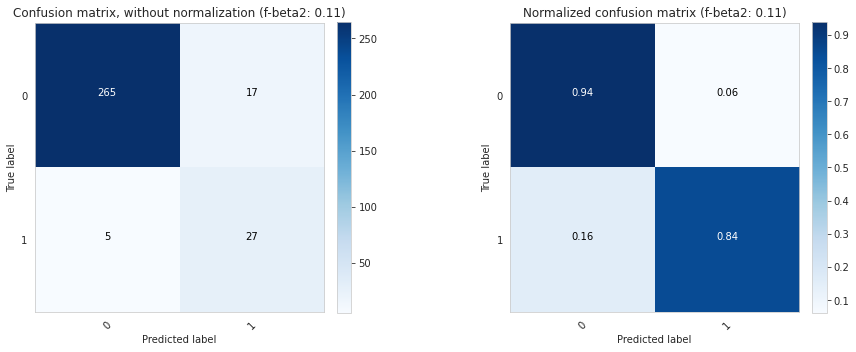



ROC Curve:


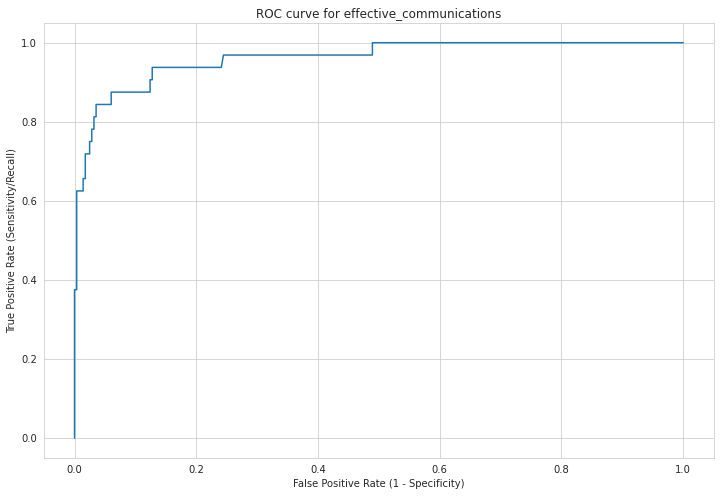

Predicted Probability Distribution:


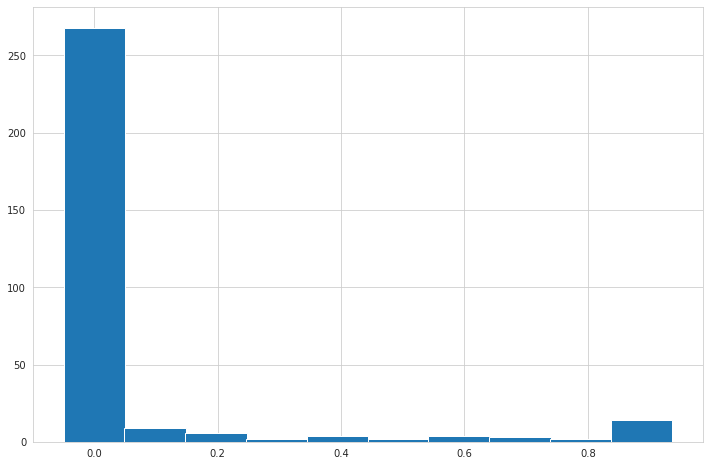



----------------------------------------------------------------------------------------------------


EFFECTIVELY_USES_WEBSITES_ONLINE_DOCUMENTATION

Null Accuracy:	0.8694267515923567
AUC Score:	0.9437148217636022

		f-beta05(0.48)		f-beta1(0.31)		f-beta2(0.11)
Accuracy:	0.9171974522292994	0.910828025477707	0.910828025477707	
Cohen's Kappa:	0.6195358374499021	0.6228875353864631	0.6631159475821902	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9458              0.9597              0.9527              273                 
1                   0.7027              0.6341              0.6667              41                  
avg/total           0.8243              0.7969              0.8097              314                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9554              0.9414  

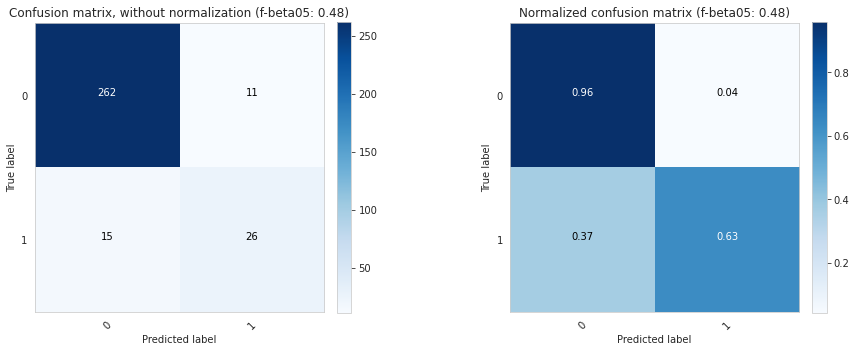

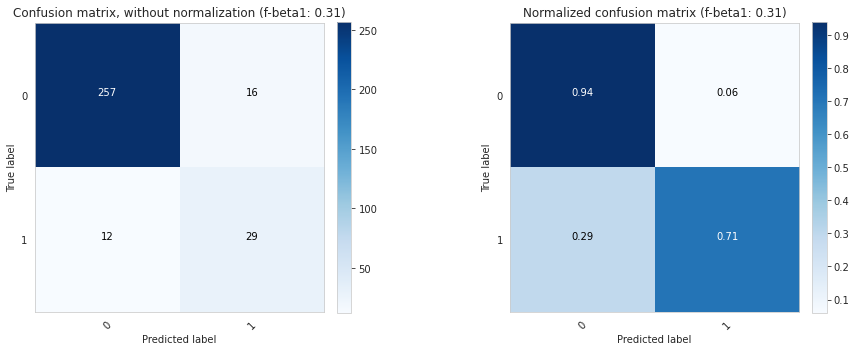

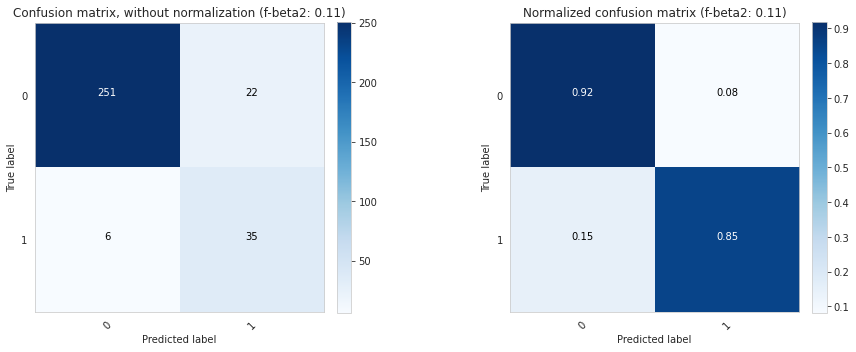



ROC Curve:


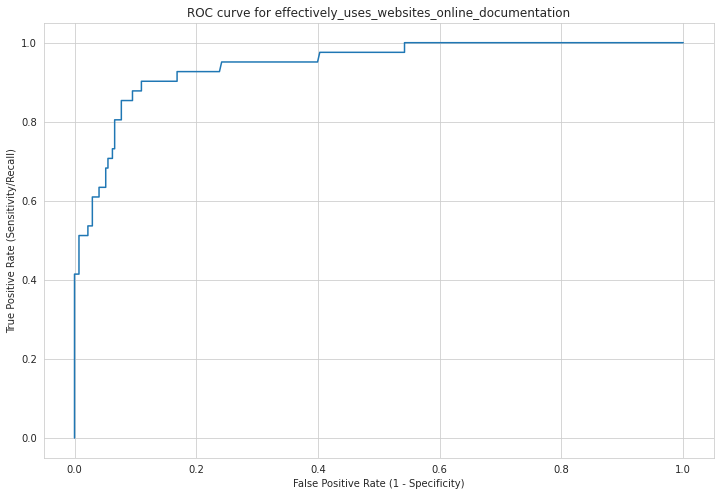

Predicted Probability Distribution:


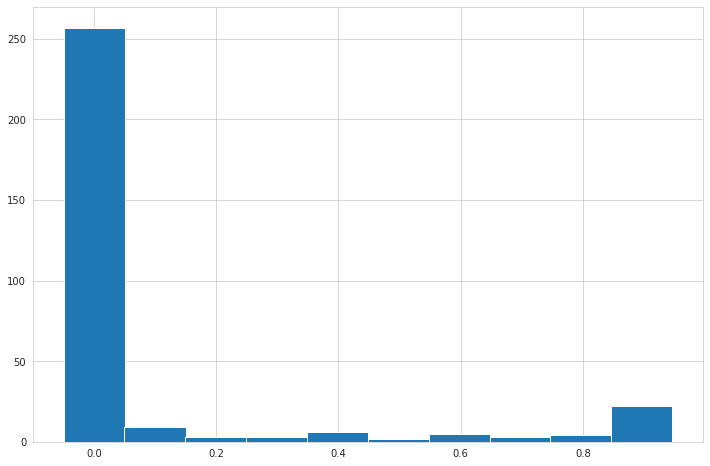



----------------------------------------------------------------------------------------------------


HELPFUL_STAFF

Null Accuracy:	0.9140127388535032
AUC Score:	0.8592076396954446

		f-beta05(0.48)		f-beta1(0.31)		f-beta2(0.11)
Accuracy:	0.9299363057324841	0.9363057324840764	0.8630573248407644	
Cohen's Kappa:	0.5222022409738553	0.6079410663004121	0.41392481986283536	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9553              0.9686              0.9619              287                 
1                   0.6087              0.5185              0.56                27                  
avg/total           0.782               0.7436              0.761               314                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9684              0.9617              0.965             

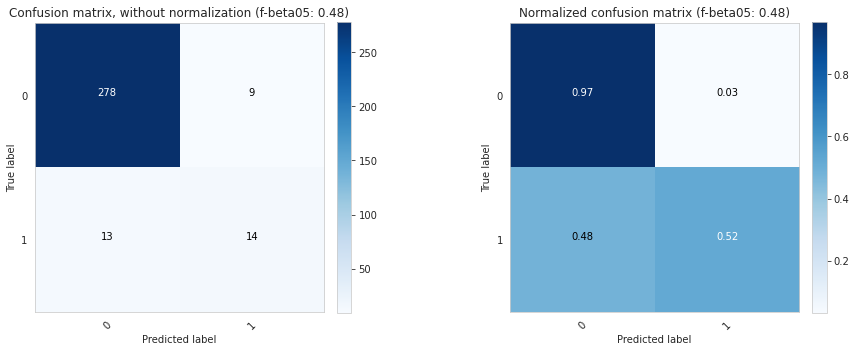

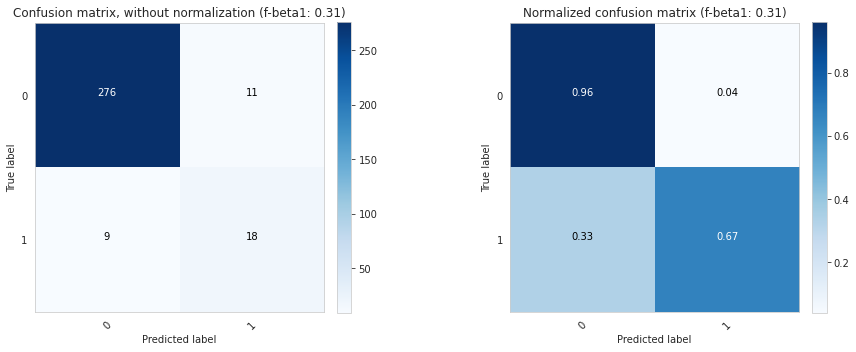

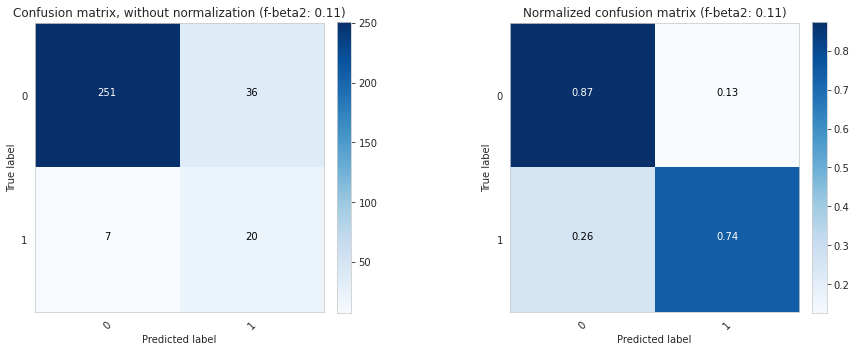



ROC Curve:


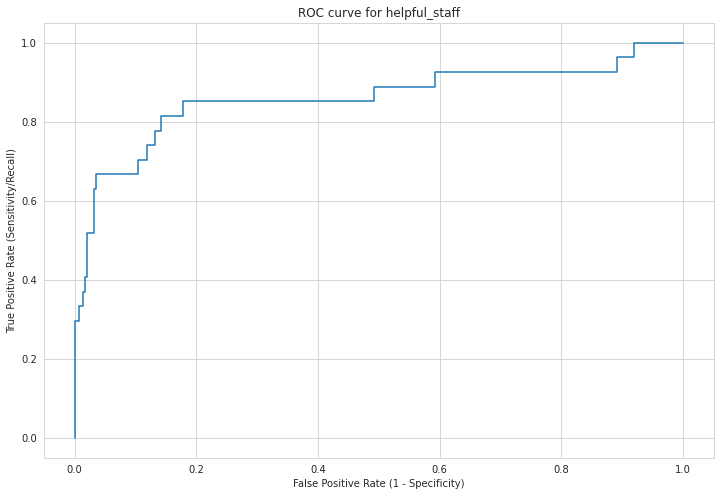

Predicted Probability Distribution:


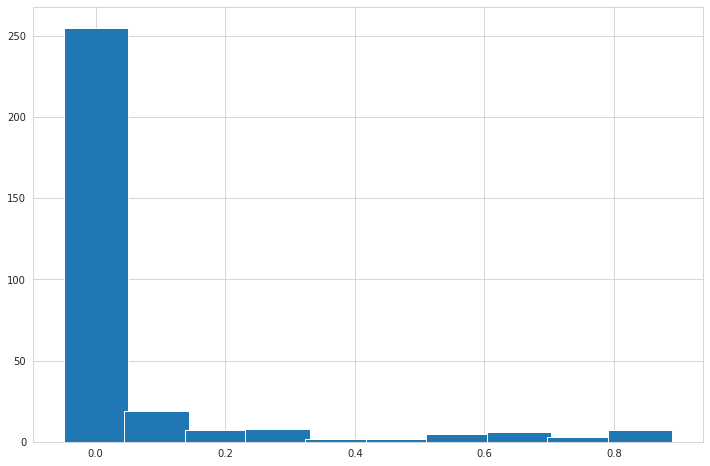



----------------------------------------------------------------------------------------------------


KNOWLEDGEABLE_STAFF

Null Accuracy:	0.9394904458598726
AUC Score:	0.9664585191793041

		f-beta05(0.48)		f-beta1(0.31)		f-beta2(0.11)
Accuracy:	0.9617834394904459	0.9554140127388535	0.9203821656050956	
Cohen's Kappa:	0.6271521868197111	0.607850133809099	0.5063514023393283	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9732              0.9864              0.9798              295                 
1                   0.7333              0.5789              0.6471              19                  
avg/total           0.8533              0.7827              0.8134              314                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9763              0.9763              0.9763        

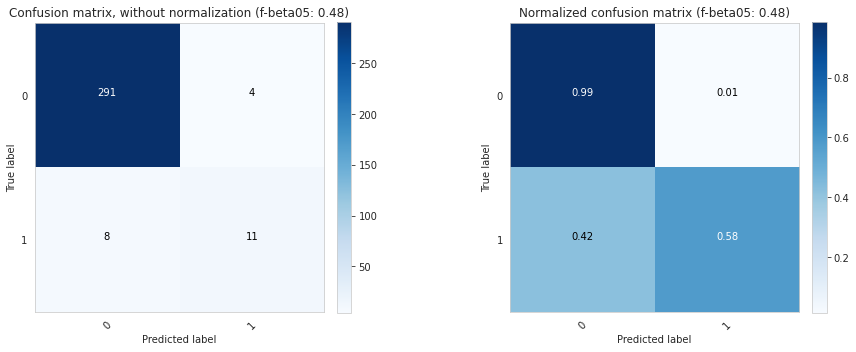

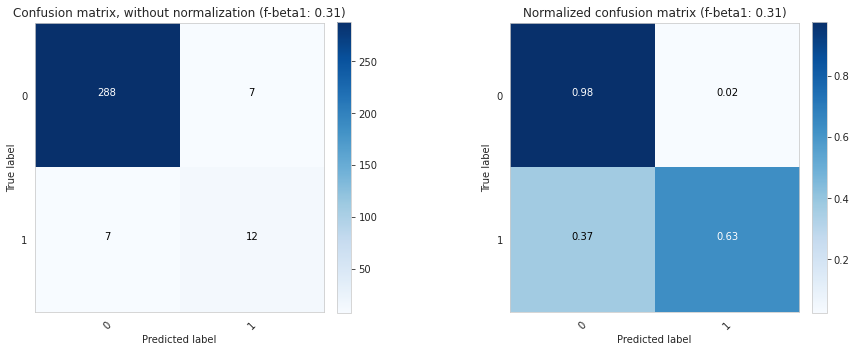

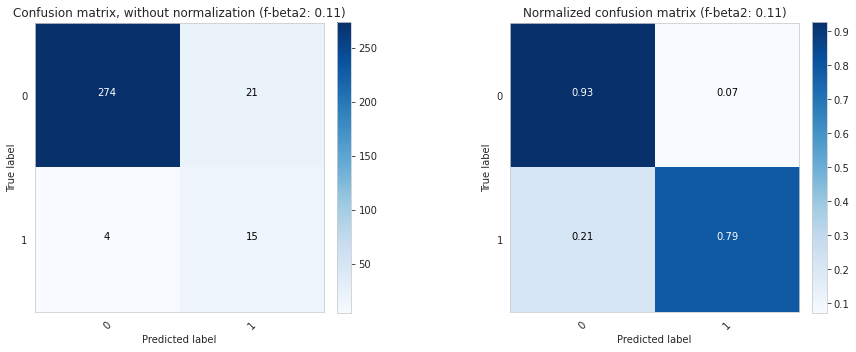



ROC Curve:


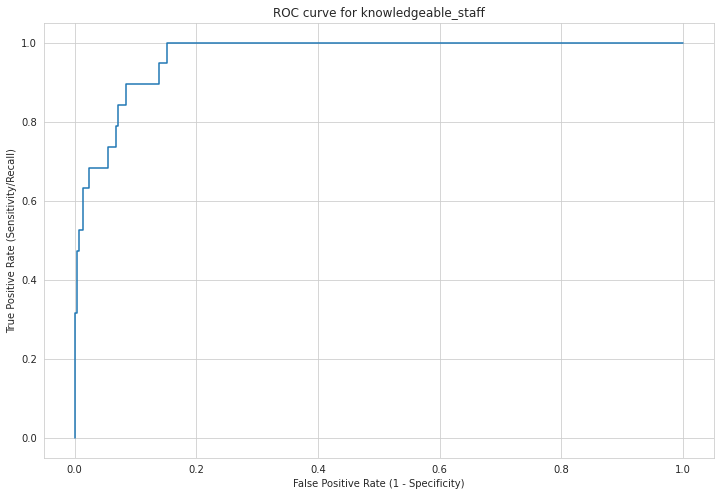

Predicted Probability Distribution:


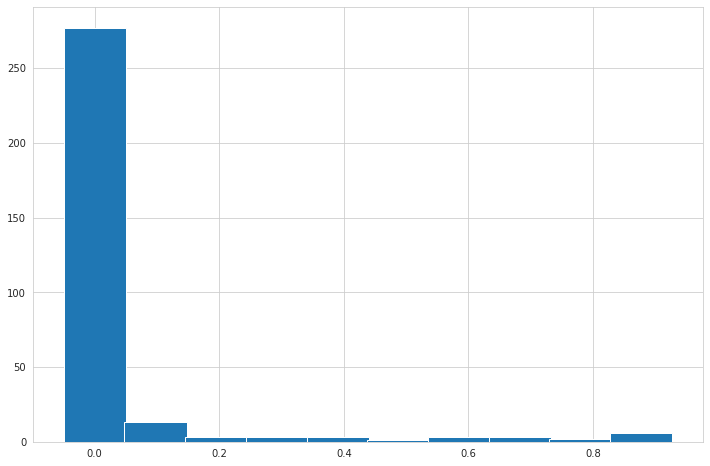



----------------------------------------------------------------------------------------------------


MOVING_IN_A_POSITIVE_DIRECTION

Null Accuracy:	0.9840764331210191
AUC Score:	0.9320388349514562

		f-beta05(0.48)		f-beta1(0.31)		f-beta2(0.11)
Accuracy:	0.9840764331210191	0.9840764331210191	0.9681528662420382	
Cohen's Kappa:	0.2791551882460973	0.4364680545585068	0.2707849512308407	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9872              0.9968              0.9919              309                 
1                   0.5                 0.2                 0.2857              5                   
avg/total           0.7436              0.5984              0.6388              314                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9903              0.9935              0.

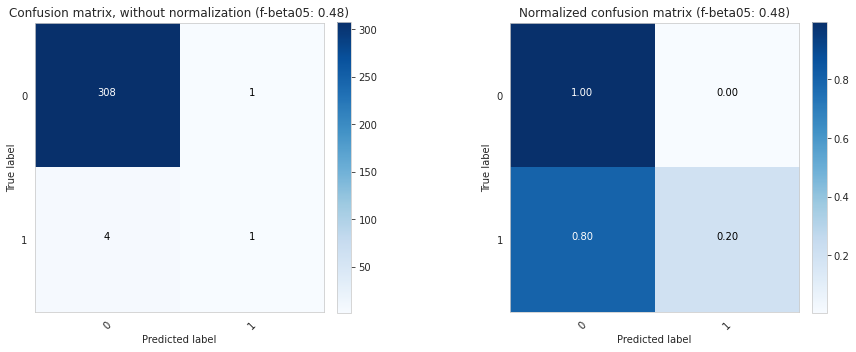

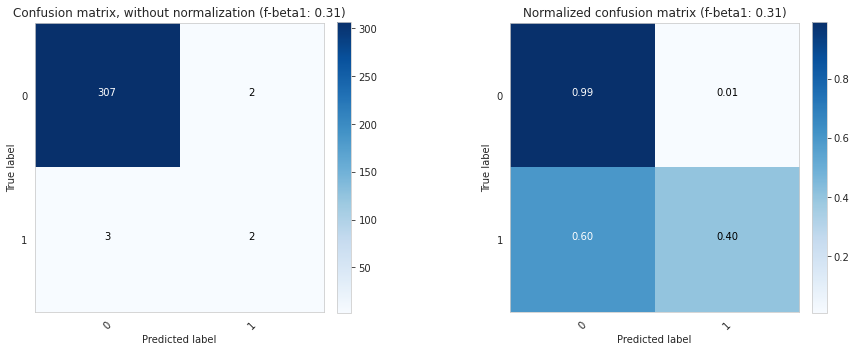

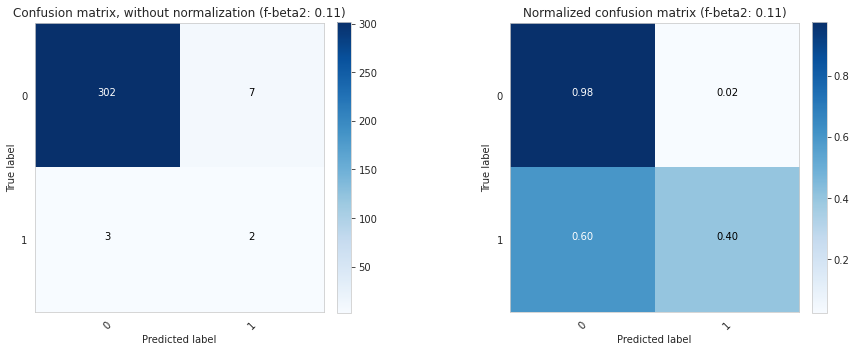



ROC Curve:


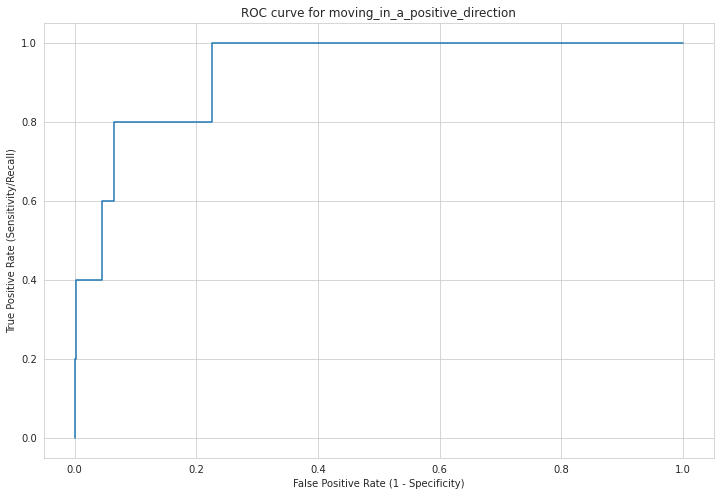

Predicted Probability Distribution:


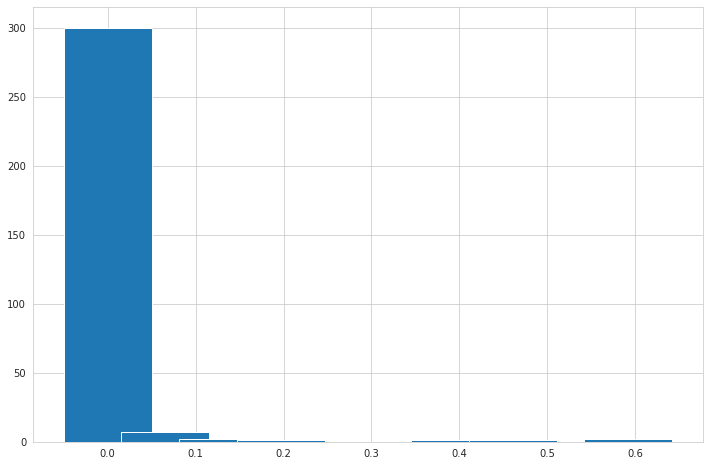



----------------------------------------------------------------------------------------------------


OVERALL_SATISFACTION

Null Accuracy:	0.9235668789808917
AUC Score:	0.9210488505747126

		f-beta05(0.48)		f-beta1(0.31)		f-beta2(0.11)
Accuracy:	0.9617834394904459	0.9681528662420382	0.9331210191082803	
Cohen's Kappa:	0.6653641207815275	0.733717774762551	0.6085717677787013	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9633              0.9966              0.9797              290                 
1                   0.9286              0.5417              0.6842              24                  
avg/total           0.946               0.7691              0.8319              314                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9698              0.9966              0.983        

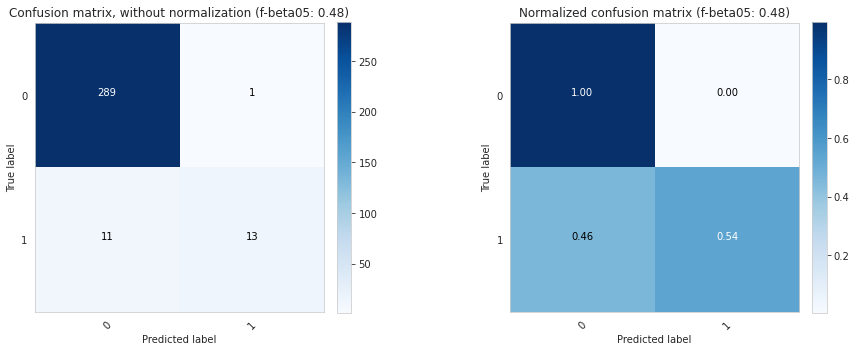

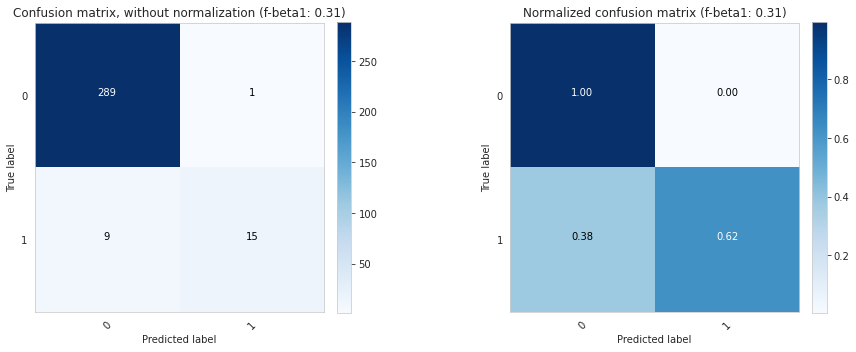

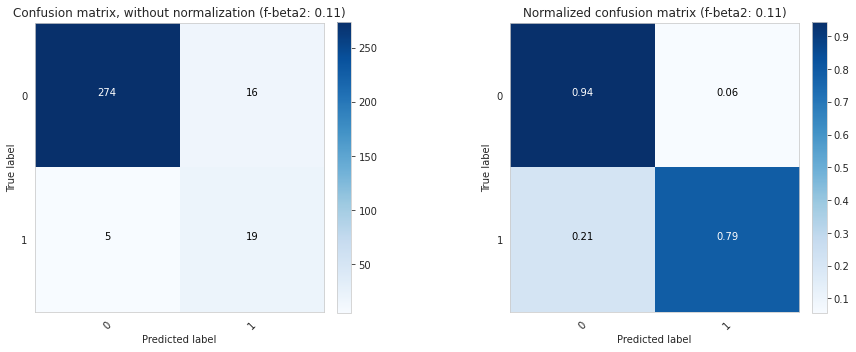



ROC Curve:


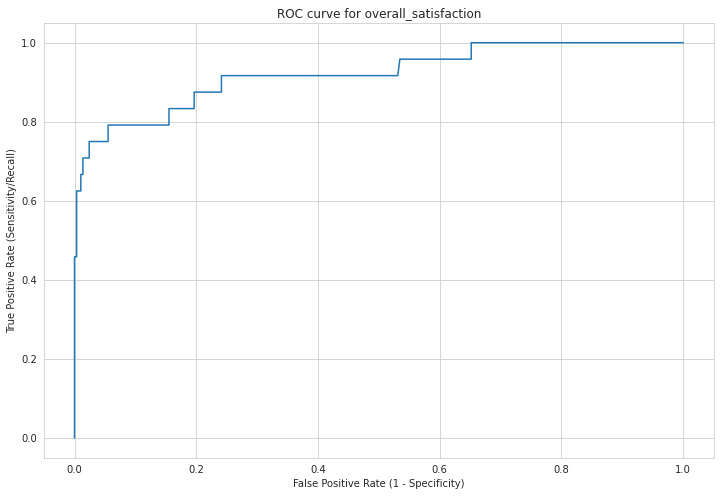

Predicted Probability Distribution:


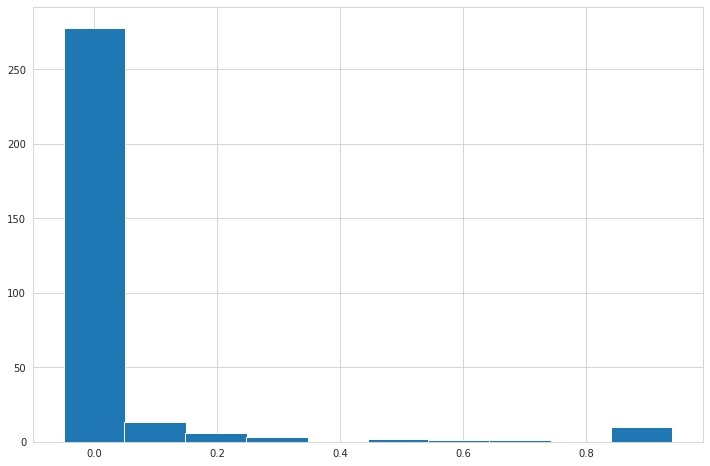



----------------------------------------------------------------------------------------------------


PROCESS_IMPROVEMENT

Null Accuracy:	0.9076433121019108
AUC Score:	0.8805202661826982

		f-beta05(0.48)		f-beta1(0.31)		f-beta2(0.11)
Accuracy:	0.9044585987261147	0.8821656050955414	0.802547770700637	
Cohen's Kappa:	0.34953735671868535	0.38313688011043845	0.3476308558407615	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9352              0.9614              0.9481              285                 
1                   0.4762              0.3448              0.4                 29                  
avg/total           0.7057              0.6531              0.674               314                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9493              0.9193              0.934       

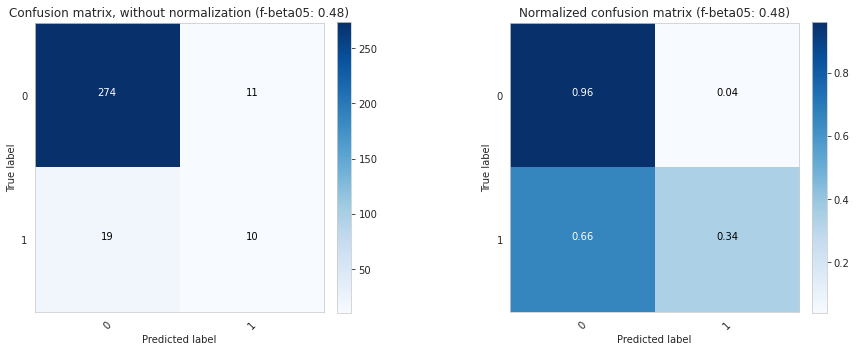

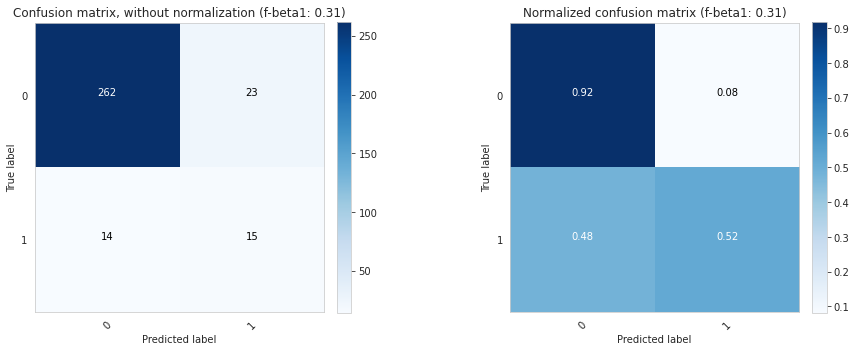

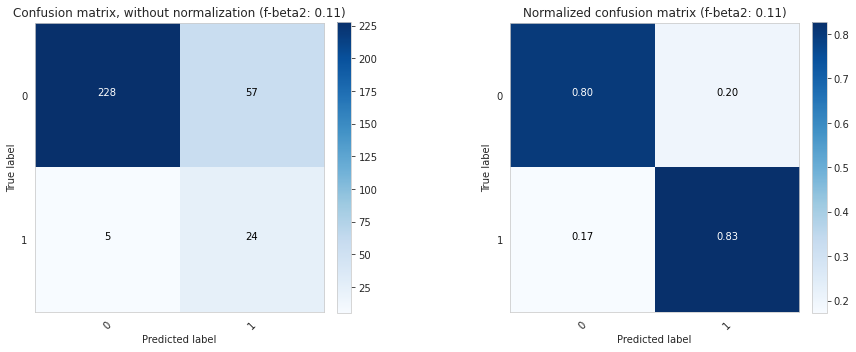



ROC Curve:


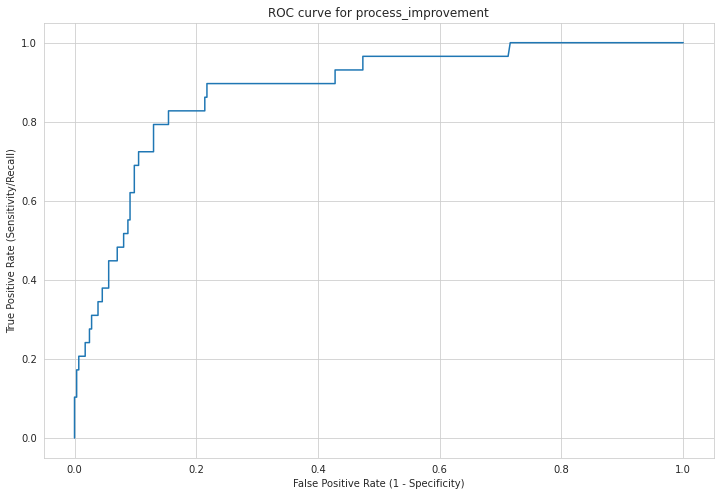

Predicted Probability Distribution:


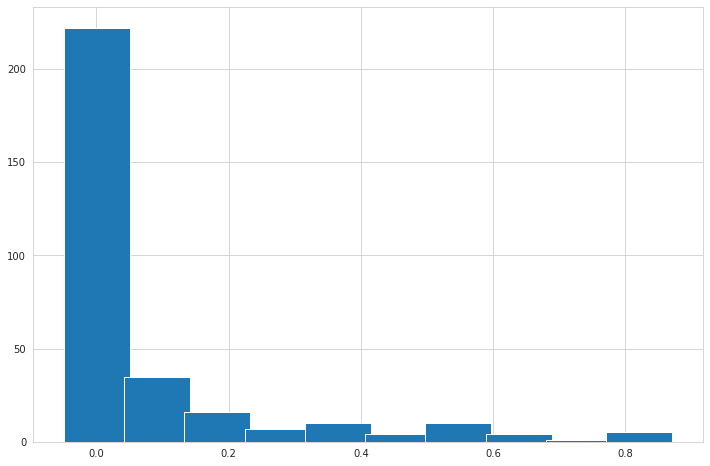



----------------------------------------------------------------------------------------------------


PROVIDES_EFFECTIVE_ADVICE_GUIDANCE

Null Accuracy:	0.9617834394904459
AUC Score:	0.8925220750551877

		f-beta05(0.48)		f-beta1(0.31)		f-beta2(0.11)
Accuracy:	0.964968152866242	0.964968152866242	0.9299363057324841	
Cohen's Kappa:	0.33806055960137993	0.5035929864903708	0.4459416105229387	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9709              0.9934              0.982               302                 
1                   0.6                 0.25                0.3529              12                  
avg/total           0.7854              0.6217              0.6675              314                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9802              0.9834             

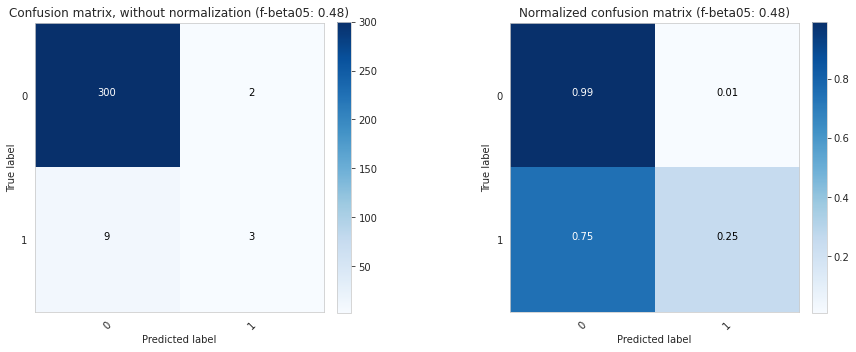

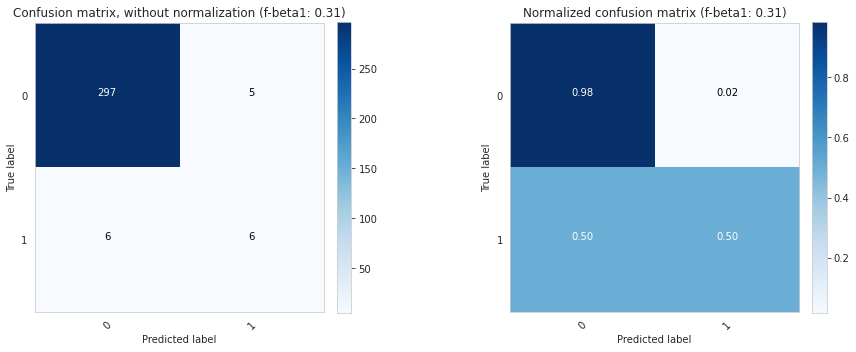

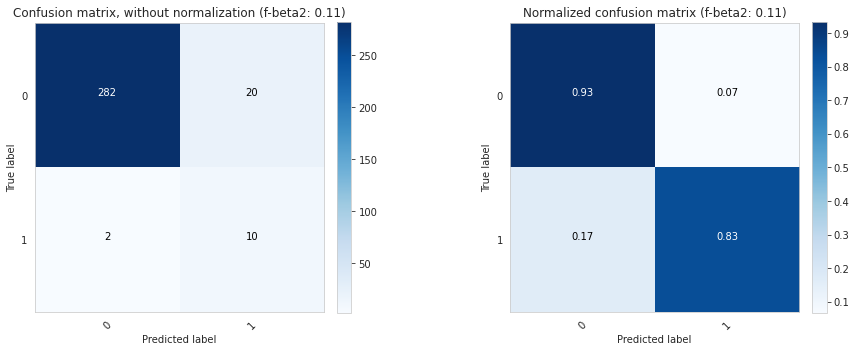



ROC Curve:


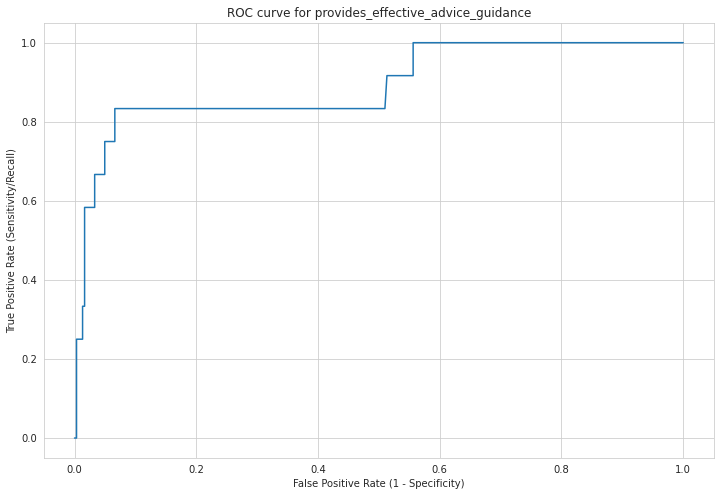

Predicted Probability Distribution:


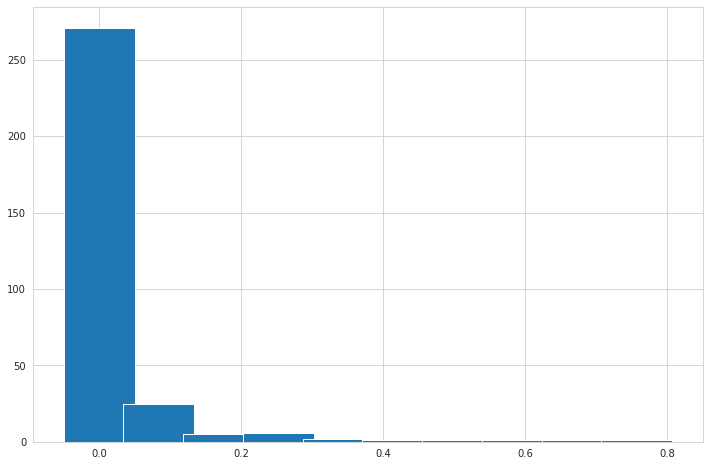



----------------------------------------------------------------------------------------------------


PROVIDES_TRAINING_ON_PROCESSES_APPLICATIONS

Null Accuracy:	0.9745222929936306
AUC Score:	0.9648692810457516

		f-beta05(0.48)		f-beta1(0.31)		f-beta2(0.11)
Accuracy:	0.9808917197452229	0.9777070063694268	0.9331210191082803	
Cohen's Kappa:	0.5618604651162791	0.6203799654576856	0.3754498958136011	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.987               0.9935              0.9902              306                 
1                   0.6667              0.5                 0.5714              8                   
avg/total           0.8268              0.7467              0.7808              314                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9934              0.9837   

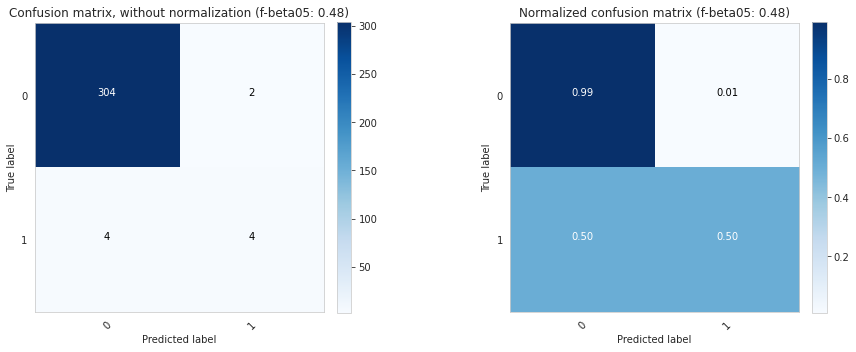

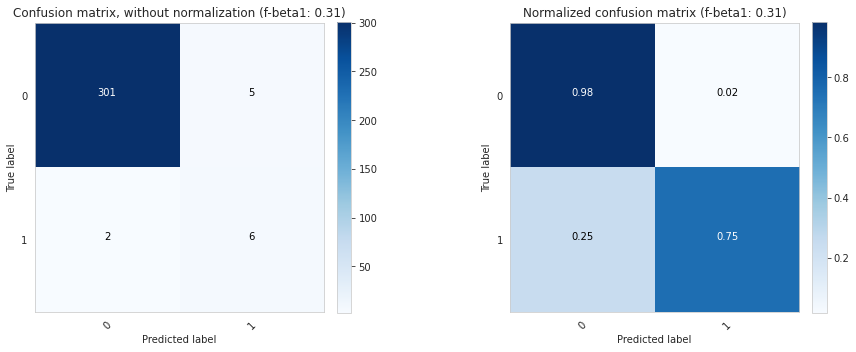

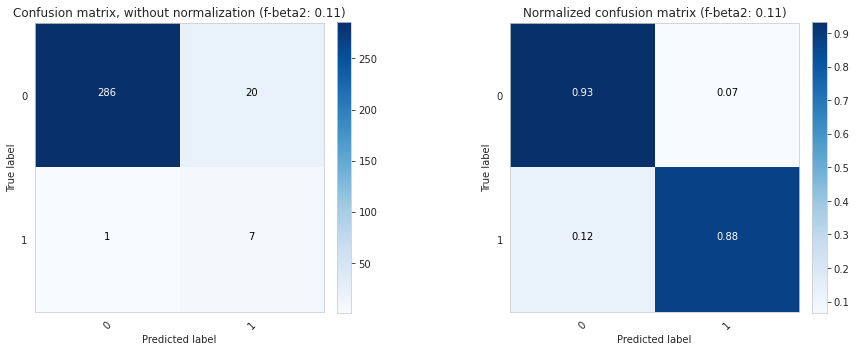



ROC Curve:


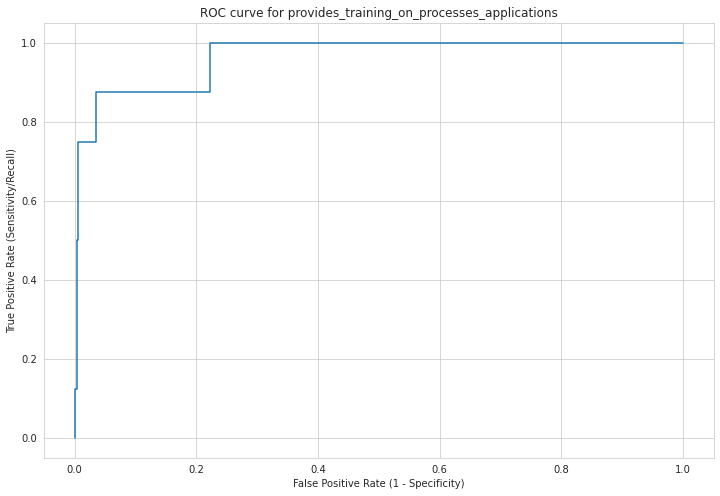

Predicted Probability Distribution:


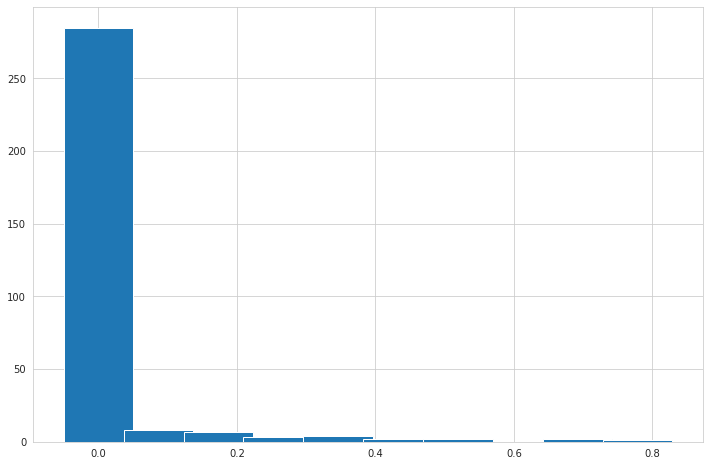



----------------------------------------------------------------------------------------------------


RESOLVES_PROBLEMS_EFFECTIVELY

Null Accuracy:	0.9171974522292994
AUC Score:	0.9126602564102564

		f-beta05(0.48)		f-beta1(0.31)		f-beta2(0.11)
Accuracy:	0.9331210191082803	0.9203821656050956	0.8757961783439491	
Cohen's Kappa:	0.40304182509505704	0.44679351656095845	0.43110656880052034	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9406              0.9896              0.9645              288                 
1                   0.7273              0.3077              0.4324              26                  
avg/total           0.8339              0.6486              0.6984              314                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9519              0.9618              

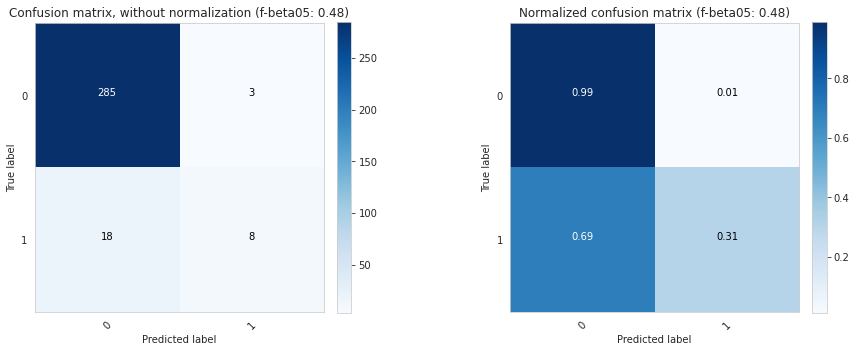

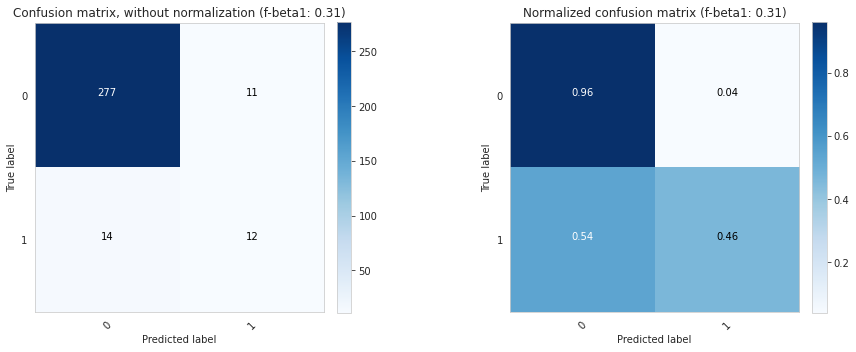

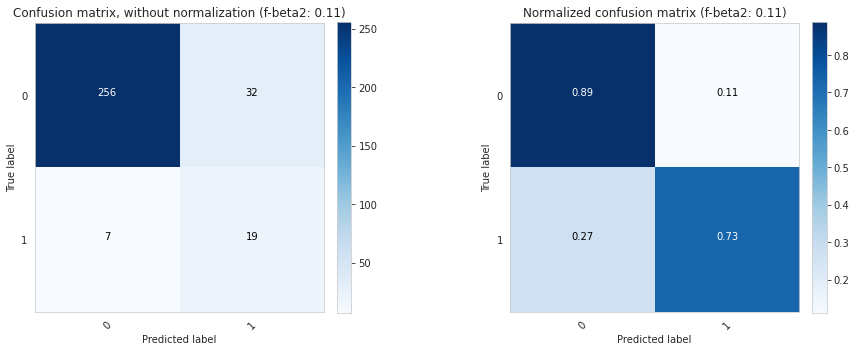



ROC Curve:


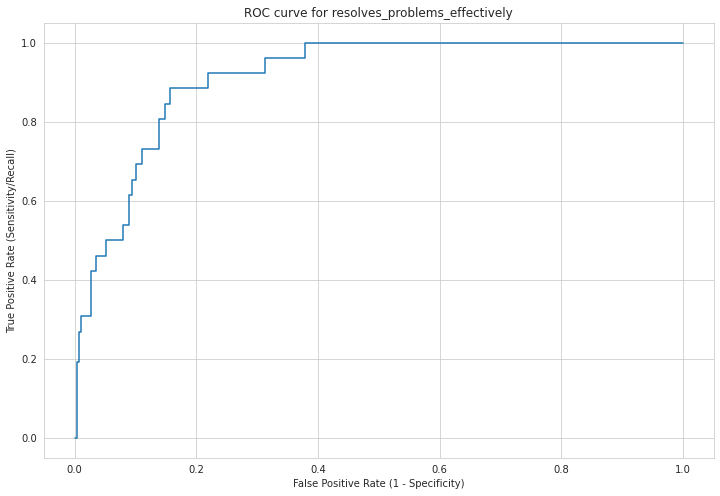

Predicted Probability Distribution:


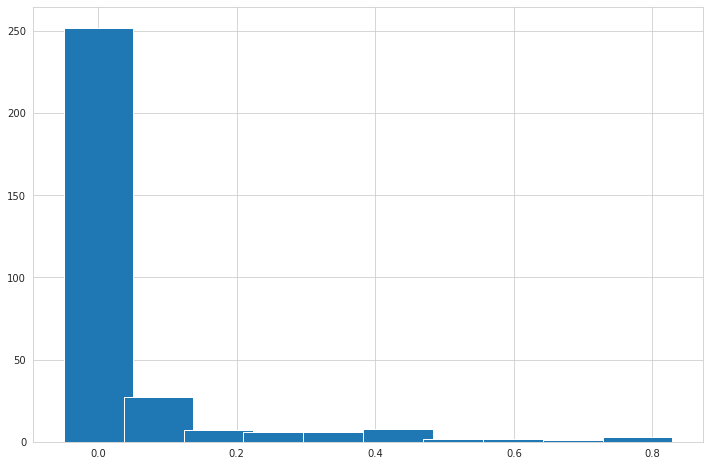



----------------------------------------------------------------------------------------------------


RESPONDS_TO_REQUESTS_WITHIN_AN_ACCEPTABLE_TIME

Null Accuracy:	0.8439490445859873
AUC Score:	0.9690412013862149

		f-beta05(0.48)		f-beta1(0.31)		f-beta2(0.11)
Accuracy:	0.9267515923566879	0.9267515923566879	0.89171974522293	
Cohen's Kappa:	0.7098433105664925	0.7330129390018485	0.6620021528525296	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9481              0.966               0.957               265                 
1                   0.7955              0.7143              0.7527              49                  
avg/total           0.8718              0.8402              0.8548              314                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9654              0.9472  

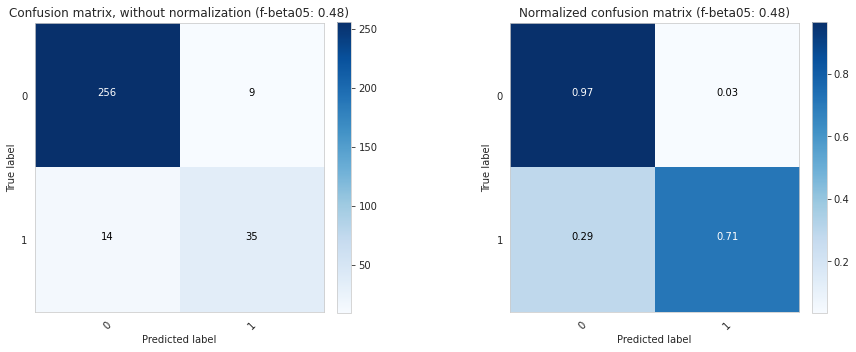

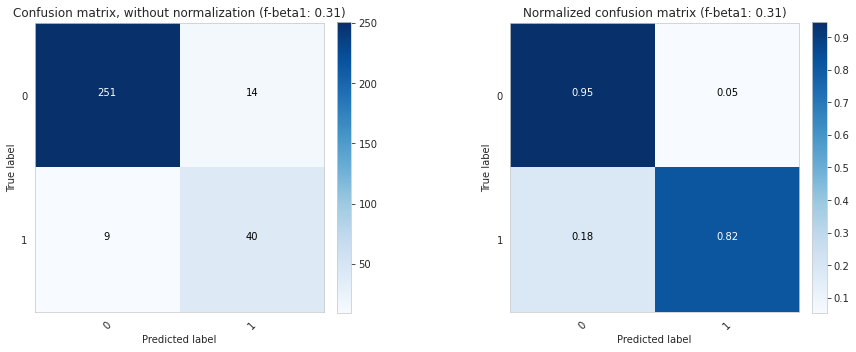

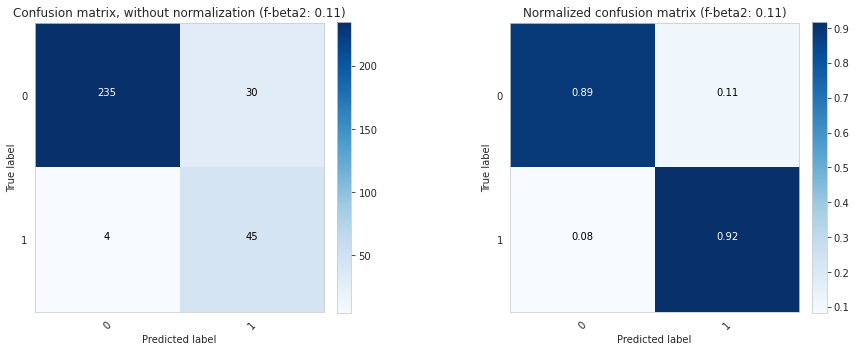



ROC Curve:


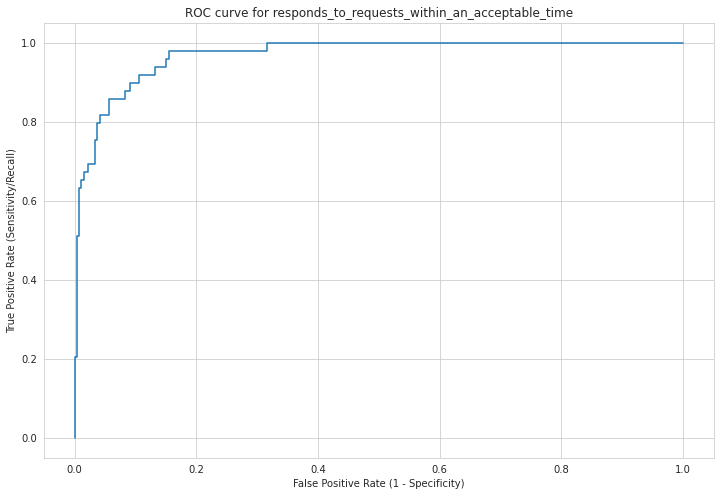

Predicted Probability Distribution:


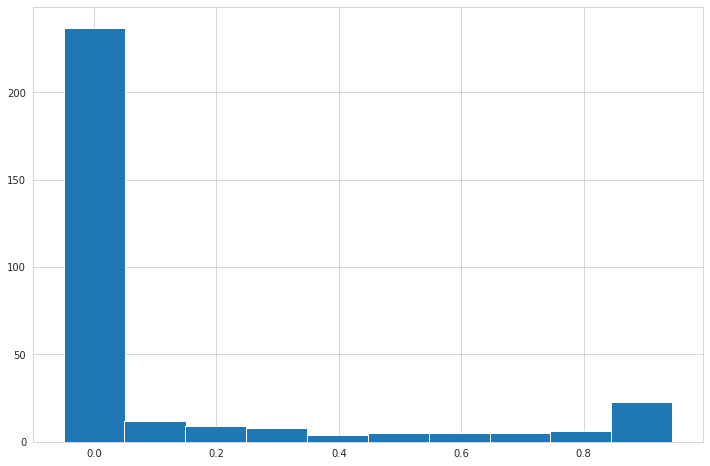



----------------------------------------------------------------------------------------------------


UNDERSTANDS_MY_NEEDS_AND_REQUIREMENTS

Null Accuracy:	0.9777070063694268
AUC Score:	0.7203350395532806

		f-beta05(0.48)		f-beta1(0.31)		f-beta2(0.11)
Accuracy:	0.9808917197452229	0.9713375796178344	0.964968152866242	
Cohen's Kappa:	0.39186571981923823	0.2931465732866433	0.24880382775119614	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9839              0.9967              0.9903              307                 
1                   0.6667              0.2857              0.4                 7                   
avg/total           0.8253              0.6412              0.6951              314                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9838              0.987         

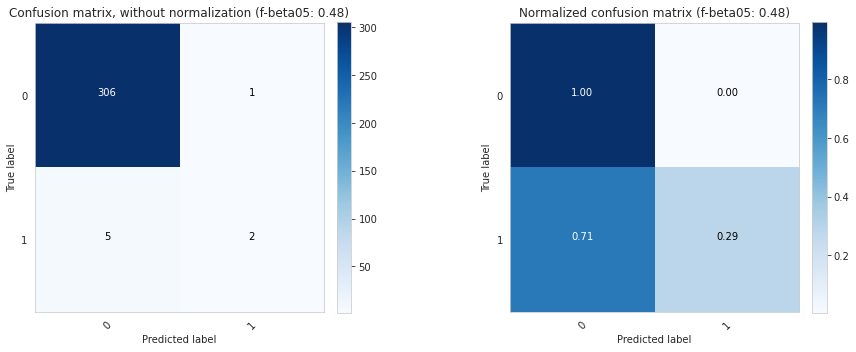

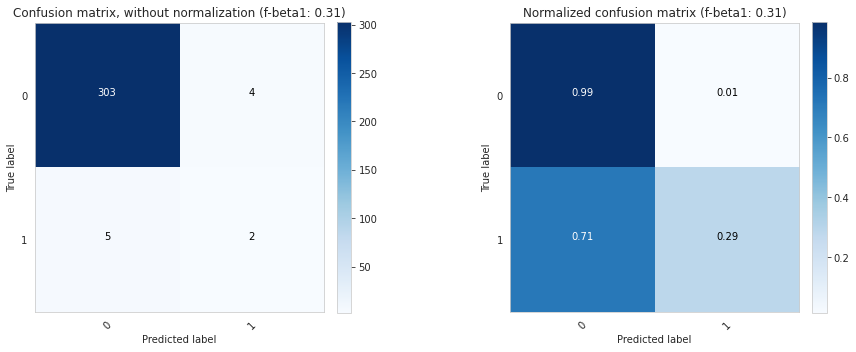

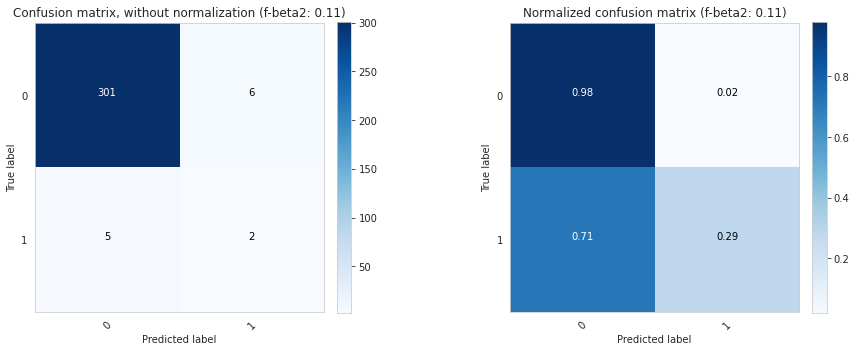



ROC Curve:


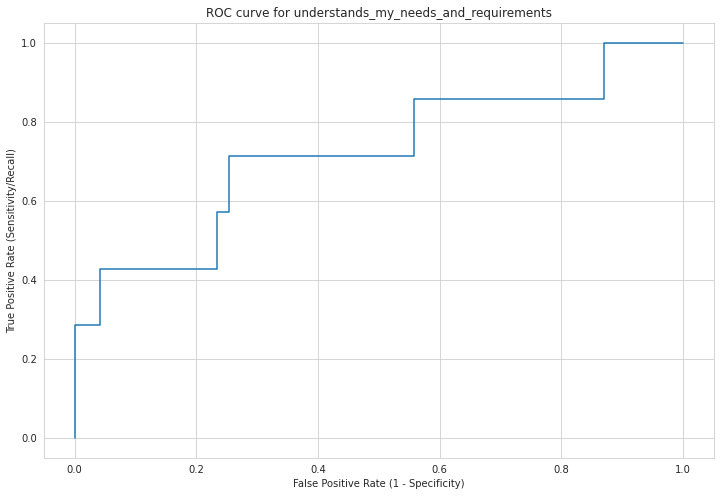

Predicted Probability Distribution:


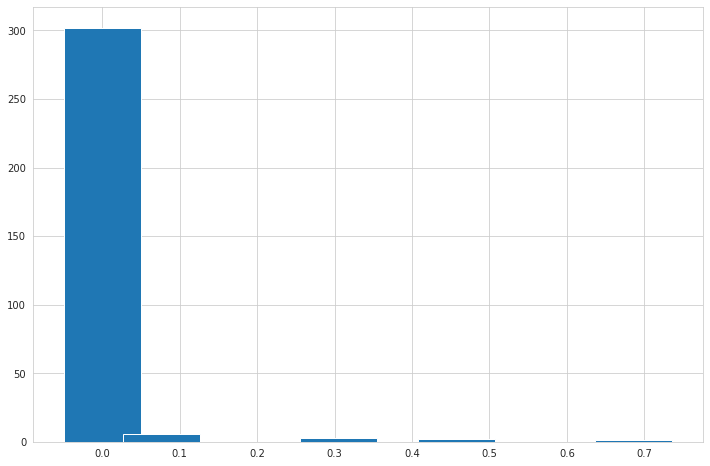



----------------------------------------------------------------------------------------------------




In [69]:
for lbl in label_metrics.keys():
    if (lbl == 'thresholds'): continue
    
    print(f'{lbl.upper()}\n')
    
    print(f'Null Accuracy:\t{label_metrics[lbl]["null_accuracy"]}')
    print(f'AUC Score:\t{label_metrics[lbl]["roc_auc"]}')
    print('')
    
    print(''.join([ f'\t\t{threshold}({np.round(v, 4)})' for threshold, v in label_metrics['thresholds'].items() ]))
    
    print('Accuracy:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["accuracies"][threshold]}\t', end='')
    print('')
    
    print('Cohen\'s Kappa:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["cohen_kappas"][threshold]}\t', end='')
    print('\n')
    
    print('Classification Reports:')
    for k in label_metrics[lbl]['report'].keys():
        print(f'{k}')
        print(f'{"":<20}' + ''.join([ f'{sub_key:<20}' for sub_key in label_metrics[lbl]['report'][k].keys() ]))
        
        for i in range(2):
            print(f'{i:<20}' + ''.join([ f'{np.round(v[i],4):<20}' 
                                      for v in label_metrics[lbl]['report'][k].values() ]))
        
        print(f'{"avg/total":<20}' + ''.join([ f'{ np.round(v.mean(),4) if (sub_key != "support") else np.round(v.sum(),4):<20}' 
                                     for sub_key, v in label_metrics[lbl]['report'][k].items() ]))
        print('')
    print('\n')
    
    print('Confusion Matrices:')
    for threshold, v in label_metrics['thresholds'].items():
        cm = label_metrics[lbl]['confusion_matrices'][threshold]
        
        # Plot non-normalized confusion matrix
        fig = plt.figure(figsize=(12,8))
        plt.subplot(1, 2, 1)
        plot_confusion_matrix(cm, classes=[0,1], 
                              title=f'Confusion matrix, without normalization ({threshold}: {np.round(v,4)})')

        # Plot normalized confusion matrix
        plt.subplot(1, 2, 2)
        plot_confusion_matrix(cm, classes=[0,1], normalize=True, 
                              title=f'Normalized confusion matrix ({threshold}: {np.round(v,4)})')

        fig.subplots_adjust(wspace=0.5)
        plt.show()
    print('\n')
    
    print('ROC Curve:')
    plt.figure(figsize=(12,8))
    plt.plot(label_metrics[lbl]['roc']['fpr'], label_metrics[lbl]['roc']['tpr'])
    plt.xlim = ([0.0, 1.0])
    plt.ylim = ([0.0, 1.0])
    plt.title(f'ROC curve for {lbl}')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.grid(True)
    plt.show()
    
    print('Predicted Probability Distribution:')
    plt.figure(figsize=(12,8))
    plt.xlim = ([0.0, 1.0])
    plt.bar(label_metrics[lbl]['probability_distribution'][1][:-1], 
            label_metrics[lbl]['probability_distribution'][0], width=0.1)
    plt.show()
    
    print('\n')
    print('-'*100)
    print('\n')
        

## Final results

In [70]:
try: del inf_learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

inf_learn = load_learner(fname=STANDARD_THEME_CSS_PATH/f'{m_pre}{base_model_name}{m_suf}_export.pkl')
inf_learn.loss_func.thresh = scores['opt_th']
dls = get_css_standard_theme_train_dls(df, hf_arch, hf_tokenizer)
inf_learn.dls = dls

In [71]:
# inf_learn.loss_func = inf_learn.loss_func.to('cuda:1')

In [72]:
probs, targs, loss = inf_learn.get_preds(with_loss=True, reorder=True)
probs.shape, targs.shape, loss.shape

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(torch.Size([314, 16]), torch.Size([314, 16]), torch.Size([314]))

In [73]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [74]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs, targs)
threshold_f1 = f1.opt_th(probs, targs)
threshold_f2 = f2.opt_th(probs, targs)

print(threshold_f05, threshold_f1, threshold_f2)

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs, targs, threshold_f2, sigmoid=False).item()

print('Fowards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs, targs, sigmoid=False)}')

0.45000000000000007 0.24000000000000005 0.11000000000000001
Fowards Only
-------------
f05:	Optimal threshold = 0.45000000000000007	(Accuracy = 0.9516321420669556)
f1:	Optimal threshold = 0.24000000000000005	(Accuracy = 0.9422770738601685)
f2:	Optimal threshold = 0.11000000000000001	(Accuracy = 0.9118232727050781)

Accuracy: 0.9518312215805054


In [75]:
final_valid_loss = loss.mean().item()

## Build our training loop for hyperparam optimization and final training

In [19]:
try: del learn; del dls
except: pass
finally: gc.collect(); torch.cuda.empty_cache()
    
yyyymmdd = datetime.today().strftime("%Y%m%d")

In [20]:
class FastAIPruningCallbackv2(TrackerCallback):
    def __init__(self, trial, monitor='valid_loss', **kwargs) -> None:
        super().__init__(monitor=monitor, **kwargs)
        self._trial = trial

    def after_epoch(self) -> None:
        super().after_epoch()
        
        value = self.recorder.values[-1][self.idx]
        if value is None: return

        self._trial.report(float(value), step=self.epoch)
        if self._trial.should_prune():
            message = "Trial was pruned at epoch {}.".format(self.epoch)
            raise optuna.TrialPruned(message)

In [21]:
#export
def train(params, trial=None, train_config={}):
          
    config = {**css_standard_themes_train_config, **train_config}    
    m_pre, m_suf, base_model_name = config['m_pre'], config['m_suf'], config['base_model_name']
    full_model_name = f'{m_pre}{base_model_name}{m_suf}'
    
    # 1. grab our huggingface objects
    task = HF_TASKS_AUTO.SequenceClassification
    hf_config = AutoConfig.from_pretrained(params["pretrained_model_name"])
    hf_config.num_labels = len(STANDARD_THEME_CSS_LABELS)
    
    if (f'{params["pretrained_model_name"]}_config_overrides' in params):
        hf_config.update(params[f'{params["pretrained_model_name"]}_config_overrides'])
    else:
        config_overrides = { k:v for k,v in params.items() if (k in hf_config.to_dict()) }
        hf_config.update(config_overrides)

    hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(params["pretrained_model_name"], 
                                                                                   task=task, 
                                                                                   config=hf_config)
    
    # 2. build our dls and learner
    df = get_css_standard_theme_train_data(train_config=config)
    train_df, valid_df = df[df.is_valid == False], df[df.is_valid == True]
    
    set_seed(TL_RAND_SEED)
    dls = get_css_standard_theme_train_dls(df, hf_arch, hf_tokenizer, train_config=config, use_cache=False)
    
    set_seed(TL_RAND_SEED)
    learn, fit_cbs = get_learner(hf_model, 
                                 dls, 
                                 train_df=None, 
                                 use_weighted_loss=params["use_weighted_loss"], 
                                 use_fp16=params["use_fp16"],
                                 add_save_model_cb=params['save_model'],
                                 train_config=config)
    
    if (trial is not None): learn.add_cb(FastAIPruningCallbackv2(trial=trial, monitor=params['optimize_for']))
    
    # 3. train
    with learn.no_logging(): 
        set_seed(TL_RAND_SEED)
        learn.fit_one_cycle(params["n_frozen_epochs"], lr_max=params["frozen_lr"], cbs=fit_cbs)
        
        learn.unfreeze()
        set_seed(TL_RAND_SEED)
        learn.fit_one_cycle(params["n_unfrozen_epochs"], 
                            lr_max=slice(params["unfrozen_lr_min"], params["unfrozen_lr_max"]), 
                            cbs=fit_cbs)
        
        # export model for inference (SavedModelCallback already saves the best model if save_mode=True)
        if (trial is None): learn.export(fname=f"{yyyymmdd}_{config['export_filename']}")
            
    # 4. evaluate
    scores = dict(zip(learn.recorder.metric_names[2:], learn.validate(cbs=[fit_cbs[-1]])))
    
    try:
        if (trial is not None): return scores[params['optimize_for']]
        
        learn.loss_func.thresh = scores['opt_th']
        probs, targs, losses = learn.get_preds(dl=dls.valid, with_loss=True)
        
        # determine optimal threshold based on desired f-score
        average, sample_weight = config['opt_beta_average'], config['opt_beta_sample_weight']

        f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)
        f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)
        f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)

        scores['f05'], scores['f1'], scores['f2'] = {}, {}, {}

        scores['f05']['threshold'] = f05.opt_th(probs, targs)
        scores['f1']['threshold'] = f1.opt_th(probs, targs)
        scores['f2']['threshold'] = f2.opt_th(probs, targs)

        scores['f05']['score'] = f05.opt_fscore(probs, targs)
        scores['f1']['score'] = f1.opt_fscore(probs, targs)
        scores['f2']['score'] = f2.opt_fscore(probs, targs)
    

        # save scores from validation set if mode == training (i.e., trial == None)
        with open(f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_scores.json", 'w') as f:
            json.dump(scores, f, indent=4)
        
        # save train/validation probs, targs, losses for review
        test_dl = dls.test_dl(df, with_labels=True)
        probs, targs, losses = learn.get_preds(dl=test_dl, with_loss=True)

        probs_df = pd.DataFrame(probs.numpy(), columns=['prob_' + lbl for lbl in STANDARD_THEME_CSS_LABELS])
        targs_df = pd.DataFrame(targs.numpy(), columns= ['targ_' + lbl for lbl in STANDARD_THEME_CSS_LABELS])
        losses_df = pd.DataFrame(losses.numpy(), columns=['loss'])
        final_df = pd.concat([df.reset_index(), probs_df, targs_df, losses_df], axis=1)
    
        final_df.to_csv(f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_results.csv", index=False)
        return scores, final_df
    
    finally:
        # cleanup
        del learn; del dls 
        del hf_arch; del hf_config; del hf_tokenizer; del hf_model

### Hyperparameter optimization

In [22]:
def after_trial_cleanup(study, trial):
    gc.collect()
    torch.cuda.empty_cache()

In [23]:
#export
def objective(trial, train_config={}):
    opt_params = {
        'pretrained_model_name': trial.suggest_categorical("pretrained_model_name", ["facebook/bart-base"]),
        
        'save_model': trial.suggest_categorical("save_model", [True, False]), 
        'use_weighted_loss': trial.suggest_categorical("use_weighted_loss", [False]),
        'use_fp16': trial.suggest_categorical("use_fp16", [True]),
        'n_frozen_epochs': trial.suggest_int("n_frozen_epochs", 1, 3),
        'n_unfrozen_epochs': trial.suggest_int("n_unfrozen_epochs", 0, 5),
        'frozen_lr': trial.suggest_loguniform("frozen_lr", 3e-3, 3e-2),
        'unfrozen_lr_max': trial.suggest_loguniform("unfrozen_lr_max", 1e-6, 1e-5),
        'unfrozen_lr_min': trial.suggest_loguniform("unfrozen_lr_min", 1e-8, 1e-6),
        'optimize_for': 'fbeta_score',
        
        'facebook/bart-base_config_overrides': {
            'activation_dropout': trial.suggest_discrete_uniform('activation_dropout', 0.0, 0.3, 0.05),
            'attention_dropout': trial.suggest_discrete_uniform('attention_dropout', 0.0, 0.3, 0.05),
            'classif_dropout': trial.suggest_discrete_uniform('classif_dropout', 0.0, 0.3, 0.05),
            'dropout': trial.suggest_discrete_uniform('dropout', 0.0, 0.3, 0.05)
        },
        'roberta-base_config_overrides': {
            'attention_probs_dropout_prob': trial.suggest_discrete_uniform('attention_probs_dropout_prob', 0.0, 0.3, 0.05),
            'hidden_dropout_prob': trial.suggest_discrete_uniform('hidden_dropout_prob', 0.0, 0.3, 0.05)
        }
    }
    
    score = train(opt_params, trial=trial, train_config=train_config)
    return score

In [24]:
start = datetime.now()

pruner = optuna.pruners.MedianPruner() if True else optuna.pruners.NopPruner()
study = optuna.create_study(direction="maximize", pruner=pruner)

train_config = {}
study.optimize(partial(objective, train_config=train_config), 
               n_trials=30, 
               callbacks=[after_trial_cleanup])#, timeout=600)

end = datetime.now()

[I 2020-10-24 10:20:05,295] A new study created in memory with name: no-name-16dd82e9-57c2-4760-b8fc-1458722b5576


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 10:27:17,292] Trial 0 finished with value: 0.612019779478788 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 3, 'n_unfrozen_epochs': 5, 'frozen_lr': 0.005889713691481389, 'unfrozen_lr_max': 2.738553008721971e-06, 'unfrozen_lr_min': 4.0631564176134224e-07, 'activation_dropout': 0.05, 'attention_dropout': 0.25, 'classif_dropout': 0.25, 'dropout': 0.0, 'attention_probs_dropout_prob': 0.2, 'hidden_dropout_prob': 0.05}. Best is trial 0 with value: 0.612019779478788.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 10:30:11,038] Trial 1 finished with value: 0.6432510080297601 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 3, 'n_unfrozen_epochs': 1, 'frozen_lr': 0.004379022474611783, 'unfrozen_lr_max': 1.087181330325301e-06, 'unfrozen_lr_min': 3.373815998841033e-07, 'activation_dropout': 0.2, 'attention_dropout': 0.0, 'classif_dropout': 0.2, 'dropout': 0.05, 'attention_probs_dropout_prob': 0.05, 'hidden_dropout_prob': 0.05}. Best is trial 1 with value: 0.6432510080297601.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 10:30:55,599] Trial 2 finished with value: 0.3654697281316475 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 1, 'n_unfrozen_epochs': 0, 'frozen_lr': 0.007764728037624121, 'unfrozen_lr_max': 1.1624245622844796e-06, 'unfrozen_lr_min': 1.6223409316935951e-07, 'activation_dropout': 0.25, 'attention_dropout': 0.2, 'classif_dropout': 0.0, 'dropout': 0.2, 'attention_probs_dropout_prob': 0.15000000000000002, 'hidden_dropout_prob': 0.1}. Best is trial 1 with value: 0.6432510080297601.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 10:38:11,734] Trial 3 finished with value: 0.062262878824182986 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 3, 'n_unfrozen_epochs': 5, 'frozen_lr': 0.014435332268597893, 'unfrozen_lr_max': 3.158405454383466e-06, 'unfrozen_lr_min': 1.9322365837163085e-07, 'activation_dropout': 0.2, 'attention_dropout': 0.1, 'classif_dropout': 0.3, 'dropout': 0.3, 'attention_probs_dropout_prob': 0.3, 'hidden_dropout_prob': 0.2}. Best is trial 1 with value: 0.6432510080297601.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.3394997985994306.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.5976699342324342.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 10:43:52,228] Trial 4 finished with value: 0.4847370973407201 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': True, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 2, 'n_unfrozen_epochs': 4, 'frozen_lr': 0.006769482438047088, 'unfrozen_lr_max': 5.249873944228356e-06, 'unfrozen_lr_min': 9.885231161659125e-08, 'activation_dropout': 0.2, 'attention_dropout': 0.3, 'classif_dropout': 0.25, 'dropout': 0.15000000000000002, 'attention_probs_dropout_prob': 0.1, 'hidden_dropout_prob': 0.3}. Best is trial 1 with value: 0.6432510080297601.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 10:44:33,495] Trial 5 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 10:45:15,204] Trial 6 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.527062164321275.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.6772586960188934.
Better model found at epoch 2 with precision_score value: 0.7109988627321252.


Better model found at epoch 0 with precision_score value: 0.7422107510385161.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.7619139321711088.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 2 with precision_score value: 0.7651979457765511.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 10:50:23,533] Trial 7 finished with value: 0.6642063525550874 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': True, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 3, 'n_unfrozen_epochs': 3, 'frozen_lr': 0.0036796903164869397, 'unfrozen_lr_max': 2.490519860334739e-06, 'unfrozen_lr_min': 1.1227112372678959e-07, 'activation_dropout': 0.0, 'attention_dropout': 0.15000000000000002, 'classif_dropout': 0.05, 'dropout': 0.0, 'attention_probs_dropout_prob': 0.2, 'hidden_dropout_prob': 0.1}. Best is trial 7 with value: 0.6642063525550874.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 10:51:04,967] Trial 8 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 10:51:47,067] Trial 9 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.5518030923879321.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.6888597900886605.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.7426097900886605.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 10:55:18,215] Trial 10 finished with value: 0.5917729263465727 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': True, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 2, 'n_unfrozen_epochs': 2, 'frozen_lr': 0.003489952063817743, 'unfrozen_lr_max': 2.0043222586420227e-06, 'unfrozen_lr_min': 1.1774579544140193e-08, 'activation_dropout': 0.0, 'attention_dropout': 0.2, 'classif_dropout': 0.1, 'dropout': 0.25, 'attention_probs_dropout_prob': 0.25, 'hidden_dropout_prob': 0.0}. Best is trial 7 with value: 0.6642063525550874.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 10:58:10,543] Trial 11 finished with value: 0.6451723521303647 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 3, 'n_unfrozen_epochs': 1, 'frozen_lr': 0.003051271249499086, 'unfrozen_lr_max': 1.6203455145143518e-06, 'unfrozen_lr_min': 3.431321934891442e-08, 'activation_dropout': 0.1, 'attention_dropout': 0.0, 'classif_dropout': 0.15000000000000002, 'dropout': 0.0, 'attention_probs_dropout_prob': 0.0, 'hidden_dropout_prob': 0.0}. Best is trial 7 with value: 0.6642063525550874.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 11:02:39,135] Trial 12 finished with value: 0.643022931152803 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 2, 'n_unfrozen_epochs': 3, 'frozen_lr': 0.0030704678458847888, 'unfrozen_lr_max': 1.8217468999112216e-06, 'unfrozen_lr_min': 3.073995829918149e-08, 'activation_dropout': 0.0, 'attention_dropout': 0.0, 'classif_dropout': 0.1, 'dropout': 0.0, 'attention_probs_dropout_prob': 0.0, 'hidden_dropout_prob': 0.0}. Best is trial 7 with value: 0.6642063525550874.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 11:03:20,787] Trial 13 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.6130112762496303.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.6715643633435227.
Better model found at epoch 2 with precision_score value: 0.7752013442676174.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[I 2020-10-24 11:08:29,722] Trial 14 finished with value: 0.6775369690431731 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': True, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 3, 'n_unfrozen_epochs': 3, 'frozen_lr': 0.0032050501961925853, 'unfrozen_lr_max': 2.3820947826364004e-06, 'unfrozen_lr_min': 6.480890435312672e-08, 'activation_dropout': 0.05, 'attention_dropout': 0.1, 'classif_dropout': 0.05, 'dropout': 0.0, 'attention_probs_dropout_prob': 0.0, 'hidden_dropout_prob': 0.05}. Best is trial 14 with value: 0.6775369690431731.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.5761790878160172.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.7203510038811762.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 11:13:46,575] Trial 16 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 11:14:28,687] Trial 17 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 11:15:10,211] Trial 18 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.5550517174082747.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 11:16:25,085] Trial 19 pruned. Trial was pruned at epoch 1.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.6884425881447157.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.7573178814244282.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 11:19:56,155] Trial 20 finished with value: 0.6238719682570243 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': True, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 2, 'n_unfrozen_epochs': 2, 'frozen_lr': 0.003066161069433331, 'unfrozen_lr_max': 3.8428440767223015e-06, 'unfrozen_lr_min': 1.9684320752164763e-08, 'activation_dropout': 0.15000000000000002, 'attention_dropout': 0.25, 'classif_dropout': 0.0, 'dropout': 0.05, 'attention_probs_dropout_prob': 0.05, 'hidden_dropout_prob': 0.25}. Best is trial 14 with value: 0.6775369690431731.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 11:21:39,185] Trial 21 pruned. Trial was pruned at epoch 2.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 11:22:51,593] Trial 22 pruned. Trial was pruned at epoch 1.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 11:23:33,504] Trial 23 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 11:24:14,191] Trial 24 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 11:24:55,823] Trial 25 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 11:25:36,999] Trial 26 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 11:26:17,934] Trial 27 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 11:27:00,021] Trial 28 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2020-10-24 11:34:12,424] Trial 29 finished with value: 0.651298301231661 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 3, 'n_unfrozen_epochs': 5, 'frozen_lr': 0.0030084417260809134, 'unfrozen_lr_max': 2.8254558528631734e-06, 'unfrozen_lr_min': 2.1575228659362188e-07, 'activation_dropout': 0.05, 'attention_dropout': 0.3, 'classif_dropout': 0.25, 'dropout': 0.0, 'attention_probs_dropout_prob': 0.25, 'hidden_dropout_prob': 0.05}. Best is trial 14 with value: 0.6775369690431731.


In [25]:
m_pre, m_suf = css_standard_themes_train_config['m_pre'], css_standard_themes_train_config['m_suf']
full_model_name = f"{m_pre}{css_standard_themes_train_config['base_model_name']}{m_suf}"

pruned_trials = [ t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED ]
complete_trials = [ t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE ]

print('Study statistics: ')
print('  Number of finished trials: ', len(study.trials))
print('  Number of pruned trials: ', len(pruned_trials))
print('  Number of complete trials: ', len(complete_trials))

print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items(): print('    {}: {}'.format(key, value))
print('  User attrs:')
for key, value in trial.user_attrs.items(): print('    {}: {}'.format(key, value))
    
best_params = study.best_params
best_params['precision_score'] = study.best_value

with open(f"{css_standard_themes_train_config['learner_path']}/{yyyymmdd}_{full_model_name}_best_trial_params.json", 'w') as f:
    json.dump(best_params, f, indent=4)

trials_df = study.trials_dataframe()
trials_df.to_csv(f"{css_standard_themes_train_config['learner_path']}/{yyyymmdd}_{full_model_name}_trial_results.csv", 
                 index=False)

print(f'total time is {(end - start).total_seconds()} seconds')

Study statistics: 
  Number of finished trials:  30
  Number of pruned trials:  18
  Number of complete trials:  12
Best trial:
  Value:  0.6775369690431731
  Params: 
    pretrained_model_name: facebook/bart-base
    save_model: True
    use_weighted_loss: False
    use_fp16: True
    n_frozen_epochs: 3
    n_unfrozen_epochs: 3
    frozen_lr: 0.0032050501961925853
    unfrozen_lr_max: 2.3820947826364004e-06
    unfrozen_lr_min: 6.480890435312672e-08
    activation_dropout: 0.05
    attention_dropout: 0.1
    classif_dropout: 0.05
    dropout: 0.0
    attention_probs_dropout_prob: 0.0
    hidden_dropout_prob: 0.05
  User attrs:
total time is 4447.452701 seconds


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/optuna/structs.py:21: FutureWarning: `structs` is deprecated. Classes have moved to the following modules. `structs.StudyDirection`->`study.StudyDirection`, `structs.StudySummary`->`study.StudySummary`, `structs.FrozenTrial`->`trial.FrozenTrial`, `structs.TrialState`->`trial.TrialState`, `structs.TrialPruned`->`exceptions.TrialPruned`.
  warnings.warn(_message, FutureWarning)


### Training with best params

In [26]:
with open(f"{css_standard_themes_train_config['learner_path']}/{yyyymmdd}_{full_model_name}_best_trial_params.json") as f: 
    best_params = json.load(f)
    
scores, train_res_df = train(params=best_params, train_config={})

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.5993868710266512.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.7537203069383677.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 2 with precision_score value: 0.7666729693917194.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.8033632638655521.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
scores

{'valid_loss': 0.145822212100029,
 'accuracy_multi': 0.9501183032989502,
 'fbeta_score': 0.6631797207091077,
 'precision_score': 0.8033632638655521,
 'recall_score': 0.465,
 'roc_auc_score': 0.7254948810022839,
 'opt_th': 0.6599999999999997,
 'f05': {'threshold': 0.42000000000000004, 'score': 0.6432775918407334},
 'f1': {'threshold': 0.28, 'score': 0.6277913796505922},
 'f2': {'threshold': 0.09000000000000001, 'score': 0.6889671419098423}}

In [28]:
train_res_df.head()

,index,id,question_ans_id,answer_text,answer_text_non_english,language,survey_id,survey_type_id,benchmark_survey_type,client_id,rsp_id,question_category_abbr,question_text,question_class,question_category_id,question_report_abbr,question_category_label,benchmark_level1,benchmark_level2,benchmark_level3,client_benchmark_level,group_code,group_id,group_level1_code,group_level1_name,group_level2_code,group_level2_name,group_level3_code,group_level3_name,group_level4_code,group_level4_name,group_level5_code,group_level5_name,group_level6_code,group_level6_name,group_level7_code,group_level7_name,group_level8_code,group_level8_name,accessible_to_customers,consistency_in_policies_information,cost_fees,courteous_professional_staff,effective_communications,effectively_uses_websites_online_documentation,helpful_staff,knowledgeable_staff,moving_in_a_positive_direction,overall_satisfaction,process_improvement,provides_effective_advice_guidance,provides_training_on_processes_applications,resolves_problems_effectively,responds_to_requests_within_an_acceptable_time,understands_my_needs_and_requirements,labels,is_valid,prob_accessible_to_customers,prob_consistency_in_policies_information,prob_cost_fees,prob_courteous_professional_staff,prob_effective_communications,prob_effectively_uses_websites_online_documentation,prob_helpful_staff,prob_knowledgeable_staff,prob_moving_in_a_positive_direction,prob_overall_satisfaction,prob_process_improvement,prob_provides_effective_advice_guidance,prob_provides_training_on_processes_applications,prob_resolves_problems_effectively,prob_responds_to_requests_within_an_acceptable_time,prob_understands_my_needs_and_requirements,targ_accessible_to_customers,targ_consistency_in_policies_information,targ_cost_fees,targ_courteous_professional_staff,targ_effective_communications,targ_effectively_uses_websites_online_documentation,targ_helpful_staff,targ_knowledgeable_staff,targ_moving_in_a_positive_direction,targ_overall_satisfaction,targ_process_improvement,targ_provides_effective_advice_guidance,targ_provides_training_on_processes_applications,targ_resolves_problems_effectively,targ_responds_to_requests_within_an_acceptable_time,targ_understands_my_needs_and_requirements,loss
0,0,602983,38342,"In the past 1-2 years, the office changed their policy to only give international postdocs J1 vi...",NaN,English,215,15,CSS-FACULTY-STAFF-ONLY,UCSD,454199,ISPO,Let us know your suggestions on how to improve the International Students & Programs Office.,Verbatim-Dept-Improve,636.0,ISPO_Improve,International Students & Programs Office,Student,Global Education,International Program,1.0,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,consistency_in_policies_information,False,0.009268,0.257205,0.070304,0.000933,0.012480,0.014064,0.010249,0.018160,0.016215,0.001310,0.320077,0.046292,0.007519,0.075041,0.024054,0.007432,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.129035
1,1,597736,12605,"The custodians are kind and competent people. However, the unit, at least in the research buildi...",NaN,English,215,15,CSS-FACULTY-STAFF-ONLY,UCSD,454041,Custodial Services,Let us know your suggestions on how to improve Custodial Services.,Verbatim-Dept-Improve,140.0,Custodial_Improve,Custodial Services,Facilities,"Building, Custodial, Facilities Maintenance",Custodial Services,1.0,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,courteous_professional_staff,False,0.002124,0.001661,0.008711,0.750553,0.001796,0.002652,0.247260,0.134890,0.003470,0.018476,0.010368,0.001721,0.001768,0.017986,0.023825,0.003456,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050915
2,2,600057,12743,CUSTOMER SERVICE TRAINING,NaN,English,215,15,CSS-FACULTY-STAFF-ONLY,UCSD,455670,Parking,Let us know your suggestions on how to improve Parking.,Verbatim-Dept-Improve,87.0,Parking_Improve,Parking,Parking & Transportation,Par

In [29]:
# load scores
with open(STANDARD_THEME_CSS_PATH/f'{yyyymmdd}_{full_model_name}_train_scores.json') as f: 
    training_results = json.load(f)
    
training_results

{'valid_loss': 0.145822212100029,
 'accuracy_multi': 0.9501183032989502,
 'fbeta_score': 0.6631797207091077,
 'precision_score': 0.8033632638655521,
 'recall_score': 0.465,
 'roc_auc_score': 0.7254948810022839,
 'opt_th': 0.6599999999999997,
 'f05': {'threshold': 0.42000000000000004, 'score': 0.6432775918407334},
 'f1': {'threshold': 0.28, 'score': 0.6277913796505922},
 'f2': {'threshold': 0.09000000000000001, 'score': 0.6889671419098423}}

In [30]:
inf_learn = load_learner(STANDARD_THEME_CSS_PATH/f'{yyyymmdd}_{full_model_name}_export.pkl')
inf_learn.loss_func.thresh = scores['opt_th']

print(inf_learn.loss_func.thresh)
print(inf_learn.blurr_predict('We are not paid enough and the benefits are horrible'))
print(inf_learn.blurr_predict("The faculty really support us well!!!  It's great working and I feel valued"))

0.6599999999999997


((#1) ['cost_fees'], tensor([False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False]), tensor([8.5640e-03, 1.3601e-03, 9.1496e-01, 8.0897e-04, 2.7057e-03, 8.1003e-04,
        3.4101e-02, 1.1731e-03, 4.7114e-04, 9.3958e-02, 3.3879e-03, 3.7730e-04,
        1.0322e-03, 8.4876e-03, 1.2125e-03, 4.3204e-03]))


((#0) [], tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]), tensor([2.7802e-03, 3.6905e-04, 9.1569e-04, 7.8049e-02, 6.2860e-03, 1.1142e-03,
        6.3420e-01, 6.9114e-03, 1.3203e-03, 3.0918e-01, 1.8139e-03, 5.6921e-04,
        1.3558e-03, 4.4384e-03, 9.4256e-04, 9.1563e-03]))


## Inference

### Inference (ad-hoc documents)

In [31]:
print(STANDARD_THEME_CSS_LABELS)

['accessible_to_customers', 'consistency_in_policies_information', 'cost_fees', 'courteous_professional_staff', 'effective_communications', 'effectively_uses_websites_online_documentation', 'helpful_staff', 'knowledgeable_staff', 'moving_in_a_positive_direction', 'overall_satisfaction', 'process_improvement', 'provides_effective_advice_guidance', 'provides_training_on_processes_applications', 'resolves_problems_effectively', 'responds_to_requests_within_an_acceptable_time', 'understands_my_needs_and_requirements']


In [32]:
test_comments = [
    'Not paid enough.',
    'I am satisfied with my benefits and we have enough people in my department. The faculty is mean to me.',
    'I love cats',
    "I can never find a parking spot. The shuttles are not on time. Help",
    "I was really uncomfortable to express my opinion!!!",
    "Jeff Wadell is an exceptional leader.  He has gone above and beyond to create a positive working environment and provide growth opportunities.  His commitment to his team is unrivaled and commendable.\\r\\n\\r\\nNikki Panza is a model of authentic leadership for Building and Custodial Services.  She has earned the respect of those she leads through honest communication, empathy, and ethical consultation."
]

for c in test_comments: print(inf_learn.blurr_predict(c, with_input=True))

(HF_BaseInput([   0, 1491, 1199,  615,    4,    2]), (#1) ['cost_fees'], tensor([False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False]), tensor([4.8555e-03, 1.8567e-03, 9.5523e-01, 6.7691e-04, 6.2975e-03, 3.1298e-04,
        2.3357e-02, 2.1352e-03, 1.5867e-03, 3.0631e-02, 2.6862e-03, 2.8246e-04,
        6.8448e-04, 5.3550e-03, 2.5617e-03, 6.0459e-03]))


(HF_BaseInput([    0,    38,   524, 10028,    19,   127,  1795,     8,    52,    33,
          615,    82,    11,   127,  1494,     4,    20,  7998,    16,  1266,
            7,   162,     4,     2]), (#0) [], tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]), tensor([2.6993e-03, 6.4205e-04, 5.0225e-03, 4.4754e-01, 1.2026e-03, 9.4982e-04,
        5.0949e-01, 1.0338e-02, 9.0660e-04, 3.2583e-02, 2.3692e-03, 4.0551e-04,
        9.2048e-04, 1.7700e-03, 2.7709e-03, 5.2392e-03]))


(HF_BaseInput([    0,    38,   657, 10017,     2]), (#1) ['overall_satisfaction'], tensor([False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False]), tensor([3.9914e-03, 1.4290e-04, 5.2295e-03, 2.4771e-02, 3.0243e-03, 7.9312e-04,
        2.1433e-01, 8.8773e-04, 4.4804e-04, 8.0110e-01, 1.8817e-03, 1.6332e-04,
        2.6477e-04, 6.3582e-03, 5.2713e-04, 8.7748e-03]))


(HF_BaseInput([    0,    38,    64,   393,   465,    10,  2932,  1514,     4,    20,
         2572,    90,  1634,    32,    45,    15,    86,     4, 10310,     2]), (#0) [], tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]), tensor([3.6051e-01, 4.5499e-04, 7.4914e-04, 2.4402e-03, 2.8620e-03, 7.1407e-04,
        9.0958e-02, 6.1818e-04, 2.2870e-02, 8.0906e-02, 4.9623e-02, 1.3445e-03,
        1.1314e-04, 6.2419e-02, 1.9200e-01, 7.3911e-02]))


(HF_BaseInput([    0,    38,    21,   269,  9800,     7,  5486,   127,  2979, 16506,
            2]), (#0) [], tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]), tensor([0.0832, 0.0007, 0.0049, 0.0200, 0.0447, 0.0102, 0.0071, 0.0005, 0.0002,
        0.1161, 0.0006, 0.0083, 0.0001, 0.0108, 0.0011, 0.0005]))


(HF_BaseInput([    0,  2321,  8914,   890,    16,    41,  9297,   884,     4,  1437,
           91,    34,  1613,  1065,     8,  1684,     7,  1045,    10,  1313,
          447,  1737,     8,   694,   434,  1616,     4,  1437,   832,  2720,
            7,    39,   165,    16,   542, 27978,   196,     8, 19781,   868,
            4, 37457,   338, 37457,   282, 37457,   338, 37457,   282, 38334,
         3144,  5302,  2478,    16,    10,  1421,     9, 12757,  1673,    13,
         6919,     8, 37513,  1630,  2617,  1820,     4,  1437,   264,    34,
         2208,     5,  2098,     9,   167,    79,  3315,   149,  5322,  4358,
            6, 17805,     6,     8, 13557,  9434,     4,     2]), (#0) [], tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]), tensor([0.0030, 0.0059, 0.0015, 0.5259, 0.0074, 0.0013, 0.3486, 0.0197, 0.0186,
        0.0436, 0.0126, 0.0376, 0.0034, 0.0922, 0.0031, 0.0121]))


### Inference (batch)

In [34]:
#export
def get_standard_theme_preds(inf_df, learner_export_path=None, train_scores_path=None, yyyymmdd=None,
                             device=torch.device('cpu'), train_config={}):
    
    config = {**css_standard_themes_train_config, **train_config}    
    m_pre, m_suf, base_model_name = config['m_pre'], config['m_suf'], config['base_model_name']
    full_model_name = f'{m_pre}{base_model_name}{m_suf}'
    
    if (yyyymmdd is None): yyyymmdd = datetime.today().strftime("%Y%m%d")
    
    # 1. grab learner, procs, and data
    cpu = device.type == 'cpu'
    if (learner_export_path is None): 
        learner_export_path = f"{config['learner_path']}/{yyyymmdd}_{config['export_filename']}"
    if (train_scores_path is None): 
        train_scores_path = f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_scores.json"
    
    with open(train_scores_path) as f: training_results = json.load(f)
        
    inf_learn = load_learner(fname=learner_export_path, cpu=cpu)
    inf_learn.loss_func.thresh = training_results['opt_th']
    inf_learn.model = inf_learn.model.to(device)
    inf_learn.model = inf_learn.model.eval()
    
    # 2. define a suitable dataloader
    inf_df.dropna(subset=config['corpus_cols'], inplace=True)
    inf_df.reset_index(drop=True, inplace=True)
    inf_dl = inf_learn.dls.test_dl(inf_df, rm_type_tfms=None, bs=16)

    # 3. get probs and document vectors
    test_probs = []
    with torch.no_grad():
        for index, b in enumerate(inf_dl):
            if index % 1000 == 0:  print(index)

            # note: even though there is no targets, each batch is a tuple!
            probs = torch.sigmoid(inf_learn.model(b[0])[0])
            
            # why "detach"? the computation of gradients wrt the weights of netG can be fully 
            # avoided in the backward pass if the graph is detached where it is.
            test_probs.append(to_detach(probs))

    all_probs = L(torch.cat(test_probs))

    # 4. ensure results are returned in order
    # test_dl.get_idxs() => unsorted/original order items
    all_probs = all_probs[0][np.argsort(inf_dl.get_idxs())]
        
    # 5. add model scores
    prob_labels = ['prob_' + lbl for lbl in STANDARD_THEME_CSS_LABELS]
    probs_df = pd.DataFrame(all_probs.numpy(), columns=prob_labels)
        
    final_df = pd.concat([inf_df, probs_df], axis=1)
    
    for lbl in STANDARD_THEME_CSS_LABELS:
        final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > training_results['opt_th']).astype(np.int64)
        
    final_df['valid_loss'] = training_results['valid_loss']
    final_df['accuracy_multi'] = training_results['accuracy_multi']
    final_df['fbeta_score'] = training_results['fbeta_score']
    final_df['precision_score'] = training_results['precision_score']
    final_df['recall_score'] = training_results['recall_score']
    final_df['roc_auc_score'] = training_results['roc_auc_score']
    final_df['opt_th'] = training_results['opt_th']
    final_df['f05_threshold'] = training_results['f05']['threshold']
    final_df['f05_score'] = training_results['f05']['score']
    final_df['f1_threshold'] = training_results['f1']['threshold']
    final_df['f1_score'] = training_results['f1']['score']
    final_df['f2_threshold'] = training_results['f2']['threshold']
    final_df['f2_score'] = training_results['f2']['score']

    # cleanup
    try: del inf_learn; del inf_dl
    except: pass
    finally: gc.collect(); torch.cuda.empty_cache()
    
    return final_df, all_probs, STANDARD_THEME_CSS_LABELS

In [48]:
verbatims_df = pd.read_csv(LM_PATH/'all.csv', dtype={**TASK_LM_DTYPES}, parse_dates=[])

inf_df = verbatims_df[verbatims_df.SurveyID == 133].copy() #verbatims_df.copy() #verbatims_df[verbatims_df.SurveyID == 130].copy()
inf_df.reset_index(drop=True, inplace=True)
print(len(verbatims_df), len(inf_df))

inf_df['answer_text'] = inf_df['AnswerText']  # ['question_text', 'answer_text']

591447 10212


In [49]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

preds_df, inf_probs, inf_labels = get_standard_theme_preds(inf_df, device=device)
print(preds_df.shape, inf_probs.shape, len(inf_labels))

cuda:1
0
(10212, 84) torch.Size([10212, 16]) 16


In [50]:
preds_df.head()

,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,answer_text,prob_accessible_to_customers,prob_consistency_in_policies_information,prob_cost_fees,prob_courteous_professional_staff,prob_effective_communications,prob_effectively_uses_websites_online_documentation,prob_helpful_staff,prob_knowledgeable_staff,prob_moving_in_a_positive_direction,prob_overall_satisfaction,prob_process_improvement,prob_provides_effective_advice_guidance,prob_provides_training_on_processes_applications,prob_resolves_problems_effectively,prob_responds_to_requests_within_an_acceptable_time,prob_understands_my_needs_and_requirements,pred_accessible_to_customers,pred_consistency_in_policies_information,pred_cost_fees,pred_courteous_professional_staff,pred_effective_communications,pred_effectively_uses_websites_online_documentation,pred_helpful_staff,pred_knowledgeable_staff,pred_moving_in_a_positive_direction,pred_overall_satisfaction,pred_process_improvement,pred_provides_effective_advice_guidance,pred_provides_training_on_processes_applications,pred_resolves_problems_effectively,pred_responds_to_requests_within_an_acceptable_time,pred_understands_my_needs_and_requirements,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,f05_threshold,f05_score,f1_threshold,f1_score,f2_threshold,f2_score
0,96712,31983,Transportation Services,NaN,English,133,24,CSS,UW,199194,NaN,<b>YES!</b> Customer Service Special Recognition to:,Verbatim-Dept-Question,NaN,Recognition_Team-1,NaN,NaN,NaN,NaN,NaN,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Transportation Services,0.028276,0.000726,0.006945,0.002030,0.000373,0.000844,0.057633,0.000289,0.014036,0.184731,0.053910,0.001892,0.001266,0.010207,0.008902,0.050374,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.145822,0.950118,0.66318,0.803363,0.465,0.725495,0.66,0.42,0.643278,0.28,0.627791,0.09,0.688967
1,98512,29009,Facilities at UW has always impressed me with their ability to maintain and improve the physical...,NaN,English,133,24,CSS,UW,198929,Facilities Maintenance & Construction,Is there anything else we should know about your experience with Facilities Maintenance & Constr...,Verbatim-Dept-Question,385.0,FacMaint_Const_Experience,Facilities Maintenance & Construction,Facilities,"Building, Custodial, Facilities Maintenance",Facilities Maintenance,1,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Facilities at UW has always impressed me with their ability to maintain and improve the physical...,0.000445,0.002806,0.001371,0.298677,0.005115,0.001757,0.124326,0.078152,0.021795,0.077009,0.051053,0.001188,0.001216,0.081651,0.066781,0.014852,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.145822,0.950118,0.66318,0.803363,0.465,0.725495,0.66,0.42,0.643278,0.28,0.627791,0.09,0.688967
2,101062,31982,Could provide more child support options,NaN,English,133,24,CSS,UW,200829,Worklife & UW Carelink,Is there anything else we should know about your experience with Worklife & UW Carelink?,Verbatim-Dept-Question,454.0,Worklife_Carelink_Experience,Worklife & UW Carelink,Human Resources,HR General Services,WorkLife Program,1,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Could provide more child support options,0.302583,0.001089,0.019373,0.000033,0.003664,0.006192,0.013700,0.000542,0.002504,0.022704,0.005278,0.010333,0.001331,0.011922,0.023101,0.004262,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.145822,0.950118,0.66318,0.803363,0.465,0.725495,0.66,0.42,0.

In [51]:
yyyymmdd = datetime.today().strftime("%Y%m%d")
preds_df.to_csv(STANDARD_THEME_CSS_PATH/f'{yyyymmdd}_test_predictions{m_suf}.csv', index=False)

*If we were building results DataFrame by hand ...*

Add the probabilities of each label to `inf_df`

In [52]:
prob_labels = ['prob_' + lbl for lbl in STANDARD_THEME_CSS_LABELS]
probs_df = pd.DataFrame(inf_probs.numpy(), columns=prob_labels)
probs_df.head()

,prob_accessible_to_customers,prob_consistency_in_policies_information,prob_cost_fees,prob_courteous_professional_staff,prob_effective_communications,prob_effectively_uses_websites_online_documentation,prob_helpful_staff,prob_knowledgeable_staff,prob_moving_in_a_positive_direction,prob_overall_satisfaction,prob_process_improvement,prob_provides_effective_advice_guidance,prob_provides_training_on_processes_applications,prob_resolves_problems_effectively,prob_responds_to_requests_within_an_acceptable_time,prob_understands_my_needs_and_requirements
0,0.028276,0.000726,0.006945,0.002030,0.000373,0.000844,0.057633,0.000289,0.014036,0.184731,0.053910,0.001892,0.001266,0.010207,0.008902,0.050374
1,0.000445,0.002806,0.001371,0.298677,0.005115,0.001757,0.124326,0.078152,0.021795,0.077009,0.051053,0.001188,0.001216,0.081651,0.066781,0.014852
2,0.302583,0.001089,0.019373,0.000033,0.003664,0.006192,0.013700,0.000542,0.002504,0.022704,0.005278,0.010333,0.001331,0.011922,0.023101,0.004262
3,0.009183,0.000871,0.000317,0.003341,0.009384,0.891373,0.007924,0.000384,0.000658,0.084629,0.074802,0.013292,0.005946,0.005497,0.001582,0.054319
4,0.196819,0.005325,0.025995,0.004754,0.009109,0.002174,0.040035,0.001687,0.188446,0.003139,0.511566,0.023396,0.012292,0.019273,0.037424,0.093745


In [53]:
final_df = pd.concat([inf_df, probs_df], axis=1)

Add in predictions based on f05 threshold

In [54]:
for lbl in STANDARD_THEME_CSS_LABELS:
    final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > scores['opt_th']).astype(np.int64)

In [55]:
final_df.head()

,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,answer_text,prob_accessible_to_customers,prob_consistency_in_policies_information,prob_cost_fees,prob_courteous_professional_staff,prob_effective_communications,prob_effectively_uses_websites_online_documentation,prob_helpful_staff,prob_knowledgeable_staff,prob_moving_in_a_positive_direction,prob_overall_satisfaction,prob_process_improvement,prob_provides_effective_advice_guidance,prob_provides_training_on_processes_applications,prob_resolves_problems_effectively,prob_responds_to_requests_within_an_acceptable_time,prob_understands_my_needs_and_requirements,pred_accessible_to_customers,pred_consistency_in_policies_information,pred_cost_fees,pred_courteous_professional_staff,pred_effective_communications,pred_effectively_uses_websites_online_documentation,pred_helpful_staff,pred_knowledgeable_staff,pred_moving_in_a_positive_direction,pred_overall_satisfaction,pred_process_improvement,pred_provides_effective_advice_guidance,pred_provides_training_on_processes_applications,pred_resolves_problems_effectively,pred_responds_to_requests_within_an_acceptable_time,pred_understands_my_needs_and_requirements
0,96712,31983,Transportation Services,NaN,English,133,24,CSS,UW,199194,NaN,<b>YES!</b> Customer Service Special Recognition to:,Verbatim-Dept-Question,NaN,Recognition_Team-1,NaN,NaN,NaN,NaN,NaN,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Transportation Services,0.028276,0.000726,0.006945,0.002030,0.000373,0.000844,0.057633,0.000289,0.014036,0.184731,0.053910,0.001892,0.001266,0.010207,0.008902,0.050374,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,98512,29009,Facilities at UW has always impressed me with their ability to maintain and improve the physical...,NaN,English,133,24,CSS,UW,198929,Facilities Maintenance & Construction,Is there anything else we should know about your experience with Facilities Maintenance & Constr...,Verbatim-Dept-Question,385.0,FacMaint_Const_Experience,Facilities Maintenance & Construction,Facilities,"Building, Custodial, Facilities Maintenance",Facilities Maintenance,1,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Facilities at UW has always impressed me with their ability to maintain and improve the physical...,0.000445,0.002806,0.001371,0.298677,0.005115,0.001757,0.124326,0.078152,0.021795,0.077009,0.051053,0.001188,0.001216,0.081651,0.066781,0.014852,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,101062,31982,Could provide more child support options,NaN,English,133,24,CSS,UW,200829,Worklife & UW Carelink,Is there anything else we should know about your experience with Worklife & UW Carelink?,Verbatim-Dept-Question,454.0,Worklife_Carelink_Experience,Worklife & UW Carelink,Human Resources,HR General Services,WorkLife Program,1,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Could provide more child support options,0.302583,0.001089,0.019373,0.000033,0.003664,0.006192,0.013700,0.000542,0.002504,0.022704,0.005278,0.010333,0.001331,0.011922,0.023101,0.004262,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,103379,31983,I think it's really cool what you guys have done to create the husky card system and everything ...,NaN,English,133,24,CSS,UW,202627,NaN,<b>YES!</b> Customer Service Special Recognition to:,Verbatim-Dept-Question,NaN,Recognition_Team-1,NaN,NaN,NaN,NaN,NaN,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I think it's really cool what you guys have done to create the husk

## Cleanup

In [56]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 02a_verbatims-core.ipynb.
Converted 02b_verbatims-sentiment.ipynb.
Converted 02c_verbatims-standard-themes-saw-training.ipynb.
Converted 02d_verbatims-standard-themes-css-training.ipynb.
Converted 02e_verbatims-standard-themes-meta-training.ipynb.
Converted 99_verbatims-inference.ipynb.
Converted index.ipynb.


## Playground

In [59]:
verbatim_id = 103379

pred_lbls = [ f'pred_{lbl}' for lbl in STANDARD_THEME_CSS_LABELS ]
prob_lbls = [ f'prob_{lbl}' for lbl in STANDARD_THEME_CSS_LABELS ]

print("=== text ===")
print(preds_df.AnswerText[preds_df.Id == verbatim_id].values[0])
print('\n=== preds ===')
preds = preds_df[pred_lbls][preds_df.Id == verbatim_id].values[0]
print([ pred_lbls[idx] for idx in np.where(preds == 1)[0] ])
print('\n=== probs ===')
probs = preds_df[prob_lbls][preds_df.Id == verbatim_id].values[0]
print([ probs[idx] for idx in np.where(preds == 1)[0] ])

=== text ===
I think it's really cool what you guys have done to create the husky card system and everything you can use it for. I also think most of your online programs like canvas and the financial aid portal are well-run.

=== preds ===
['pred_effectively_uses_websites_online_documentation']

=== probs ===
[0.8913734]
